# Сборный проект — 2

**Описание проекта**

HR-аналитики компании помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Задача 1: предсказание уровня удовлетворённости сотрудника**

Для этой задачи заказчик предоставил данные с признаками:

id — уникальный идентификатор сотрудника;

dept — отдел, в котором работает сотрудник;

level — уровень занимаемой должности;

workload — уровень загруженности сотрудника;

employment_years — длительность работы в компании (в годах);

last_year_promo — показывает, было ли повышение за последний год;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

salary — ежемесячная зарплата сотрудника;

job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Задача 1: Загрузка данных

In [2]:
!pip install scikit-learn==1.1.3 -q
!pip install missingno -q
!pip install phik -q
!pip install shap -q
!pip install optuna-integration[sklearn] -q

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures, 
                                   OneHotEncoder, 
                                   MinMaxScaler, 
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   RobustScaler)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (cross_val_score, 
                                     GridSearchCV, 
                                     cross_val_score)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import phik
import shap
from phik import resources, phik_matrix
import missingno as msno
import optuna
from optuna.integration import OptunaSearchCV 
from optuna import distributions
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

In [35]:
train_job_st = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_st = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

train_job_st.name = 'train_job_st'
test_features.name = 'test_features'
test_target_job_st.name = 'test_target_job_st'

present_files = [train_job_st, test_features, test_target_job_st]

pd.set_option('display.max_columns', None)

for i in present_files:
    print ('\n', i.name)
    display(i.sample(10))


 train_job_st


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1658,599764,sales,middle,medium,1,yes,yes,4,38400,0.68
2282,197236,technology,junior,medium,2,no,no,4,26400,0.67
1739,777604,hr,junior,low,1,no,no,4,16800,0.70
3851,362254,sales,middle,medium,10,no,no,4,38400,0.75
469,256960,sales,sinior,medium,5,no,yes,4,45600,0.37
3877,947224,technology,junior,medium,3,no,no,1,30000,0.38
3321,466755,sales,middle,medium,7,no,no,1,32400,0.38
582,631167,purchasing,middle,medium,2,no,no,4,45600,0.71
228,744464,marketing,junior,medium,1,no,yes,4,28800,0.56
457,169472,marketing,middle,medium,7,no,no,2,39600,0.40



 test_features


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
775,244854,marketing,middle,high,5,no,no,4,52800
166,554729,sales,middle,medium,6,no,no,4,33600
1671,128739,sales,middle,high,7,no,yes,2,55200
1638,385427,technology,middle,low,3,no,no,2,33600
928,392999,purchasing,junior,high,2,no,no,4,39600
150,968044,technology,middle,medium,2,no,no,5,51600
1579,998900,marketing,middle,medium,7,no,no,3,45600
1756,988734,purchasing,junior,medium,2,no,no,3,25200
497,268079,sales,middle,low,7,no,no,4,28800
1667,168007,marketing,middle,medium,4,no,no,4,46800



 test_target_job_st


,id,job_satisfaction_rate
1016,112822,0.56
881,482624,0.34
781,665832,0.31
313,774585,0.64
736,815744,0.34
1611,982787,0.75
660,726880,0.29
1840,808868,0.58
1350,514751,0.35
1618,877434,0.42


In [36]:
for i in present_files:
    print('\n', i.name, '\n',)
    display(i.info())


 train_job_st 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None


 test_features 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None


 test_target_job_st 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

In [37]:
for i in present_files:
    print('\n', i.name, '\n',)
    display(i.describe())


 train_job_st 



,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



 test_features 



,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



 test_target_job_st 



,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


**Сразу видим, что в таблицах есть немного пропусков, также присутствуют определенные выборсы, о чем говорит разница между медианами и средним.**


 train_job_st


<AxesSubplot:>

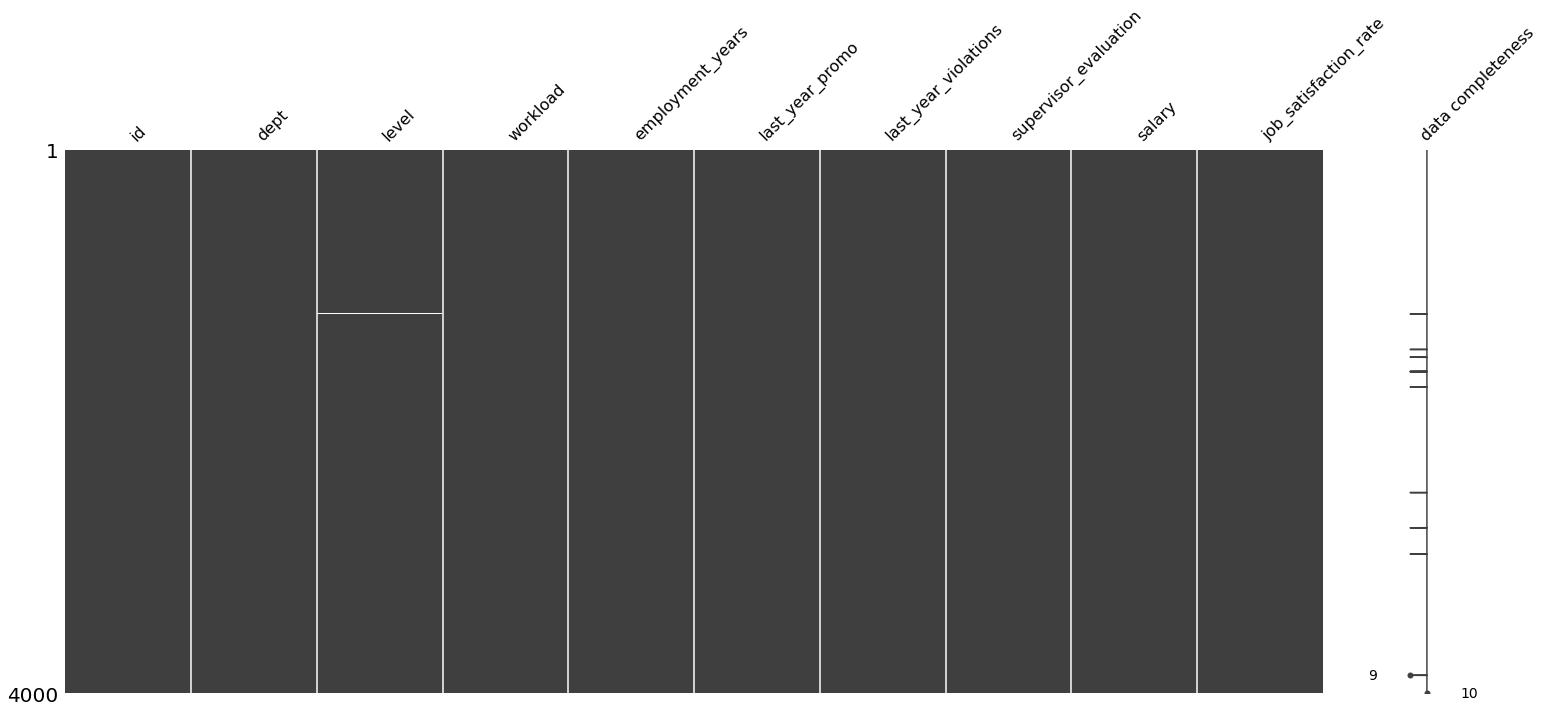


 test_features


<AxesSubplot:>

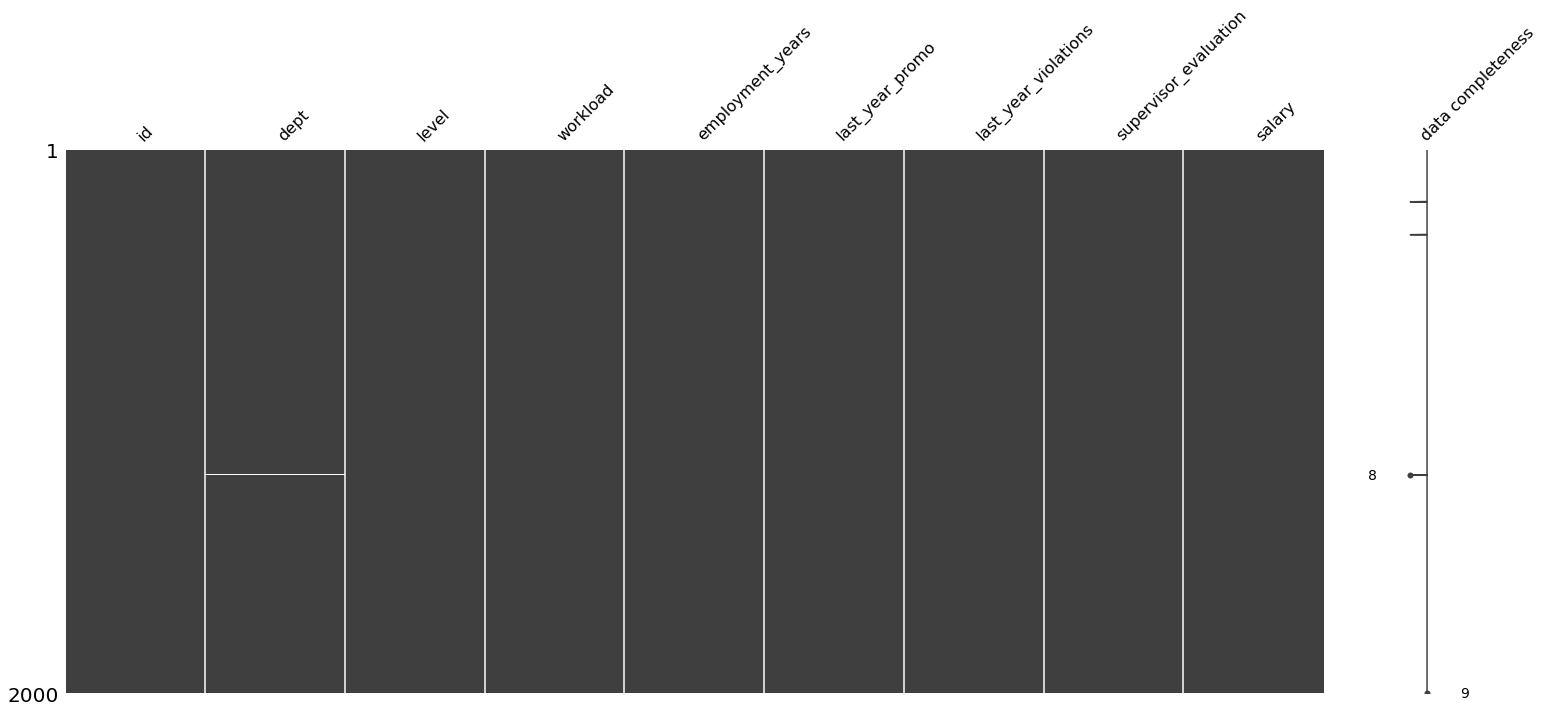

In [38]:
for i in present_files[0:2]:
    print ('\n', i.name)
    display (msno.matrix(i, labels=True))
    plt.show()


 train_job_st


<AxesSubplot:>

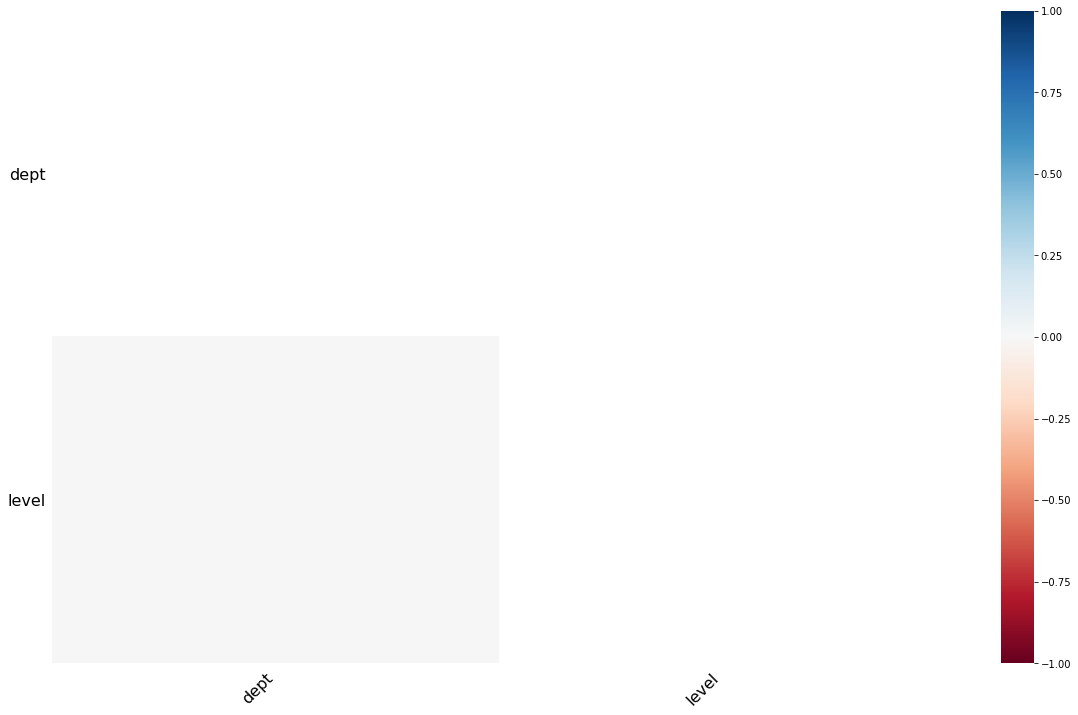


 test_features


<AxesSubplot:>

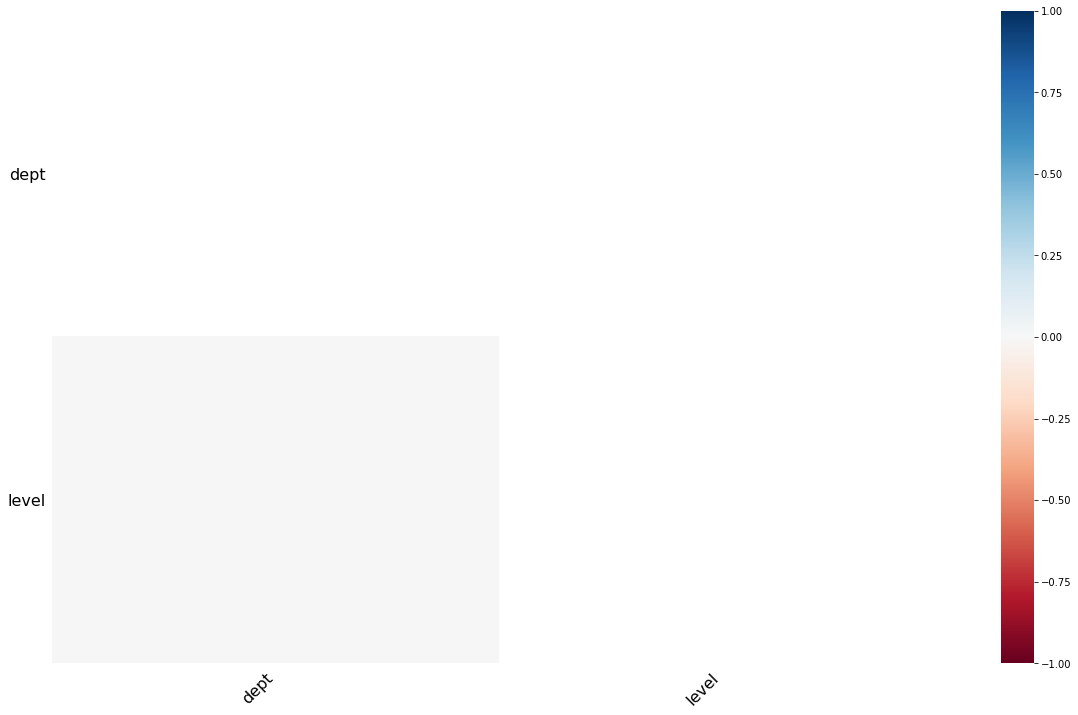

In [39]:
for i in present_files[0:2]:
    print ('\n', i.name)
    display (msno.heatmap(i, labels=True))
    plt.show()

**Видим пропуски в колонках Dept и Level таблиц train_job_satisfaction_rate и test_features. Согласно анализу корреляции - пропуски между собой на связаны. Будем разибраться и смотреть детально в предобработке**

### Вижу следующие проблемы:
- **Есть незначительные пропуски в двух таблицах;**
- **Есть определенные выбросы в количественных данных;**
- **Нужно проверить на явные и неявные дубликаты.**

## Задача 1:  Предобработка данных

In [40]:
def str_lower(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    cat = df.select_dtypes(exclude='number').columns.tolist()
    for i in cat:
        df[i] = df[i].astype(str).str.lower()
    return df

def check_errors(df):
    check = df.select_dtypes(exclude='number').columns.tolist()
    for k in check:
        df[k] = df[k].str.replace(' ','_')
        print (df.name,'-', k)
        display(df[k].value_counts())

In [41]:
for i in present_files:
    str_lower(i)
    check_errors(i)

train_job_st - dept


sales         1512
technology     866
purchasing     610
marketing      550
hr             456
nan              6
Name: dept, dtype: int64

train_job_st - level


junior    1894
middle    1744
sinior     358
nan          4
Name: level, dtype: int64

train_job_st - workload


medium    2066
low       1200
high       734
Name: workload, dtype: int64

train_job_st - last_year_promo


no     3880
yes     120
Name: last_year_promo, dtype: int64

train_job_st - last_year_violations


no     3441
yes     559
Name: last_year_violations, dtype: int64

test_features - dept


sales         763
technology    455
marketing     279
purchasing    273
hr            227
nan             2
_               1
Name: dept, dtype: int64

test_features - level


junior    974
middle    854
sinior    171
nan         1
Name: level, dtype: int64

test_features - workload


medium    1043
low        593
high       363
_            1
Name: workload, dtype: int64

test_features - last_year_promo


no     1937
yes      63
Name: last_year_promo, dtype: int64

test_features - last_year_violations


no     1738
yes     262
Name: last_year_violations, dtype: int64

**Привел названия столбцов и текстовые данные дополнительно к нижнему регистру и заменил пробелы сразу на нижнее подчеркивание. Благодаря этому обнаружил опечатку также в test_features[workload] и устранил ее в последствии**

In [42]:
train_job_st['level'] = train_job_st['level'].replace('sinior', 'senior')
train_job_st['level'].value_counts()

test_features['level'] = test_features['level'].replace('sinior', 'senior')
test_features['level'].value_counts()

test_features['workload'].value_counts()

medium    1043
low        593
high       363
_            1
Name: workload, dtype: int64

**Обнаружены дубликаты в тренировочной выборке. Устранены**

In [117]:
print(train_job_st.duplicated(subset=train_job_st.columns[1:]).sum())
train_job_st = train_job_st.drop_duplicates(subset=train_job_st.columns[1:], keep='first')

0


### Итоги раздела:
- **Опечатки устранены**
- **Явные дубликаты устранены в тренировочной выборке**

## Задача 1: Исследовательский анализ данных

In [45]:
def hist(first_df, second_df, target, bins, title, xname):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=first_df[target], bins=bins, alpha=0.5, color='blue', #добавлено 2 параметра для нормализации выборок
                 label='Тренировочная', stat='density', common_norm=False)
    sns.histplot(data=second_df[target], bins=bins, alpha=0.5, color='red', 
                 label='Тестовая', stat='density', common_norm=False)
    plt.title(f'График распределения {title}', fontsize=14)
    plt.xlabel(f'{xname}', fontsize=14)
    plt.ylabel('Частота наблюдений', fontsize=14)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    
def pie(df,title,angle,ax):
    counts = df.value_counts()
    ax.pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        startangle=angle, 
        textprops={'fontsize': 14}, 
        radius=1.2
    )
    ax.set_title(f'Диаграмма соотношения {title}', fontsize=17)

def box(df,x,title,xname): 
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x=x, palette='pastel')
    plt.title(f'Анализ показателей {title}', fontsize=14)
    plt.xlabel(f'{xname}', fontsize=14)
    plt.xticks(fontsize=10)
    plt.grid(True)
    plt.show()

### Анализ категориальных данных в таблицах

In [46]:
train_job_st_categorial = train_job_st.select_dtypes(exclude='number').columns.tolist()
print(train_job_st_categorial)

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']


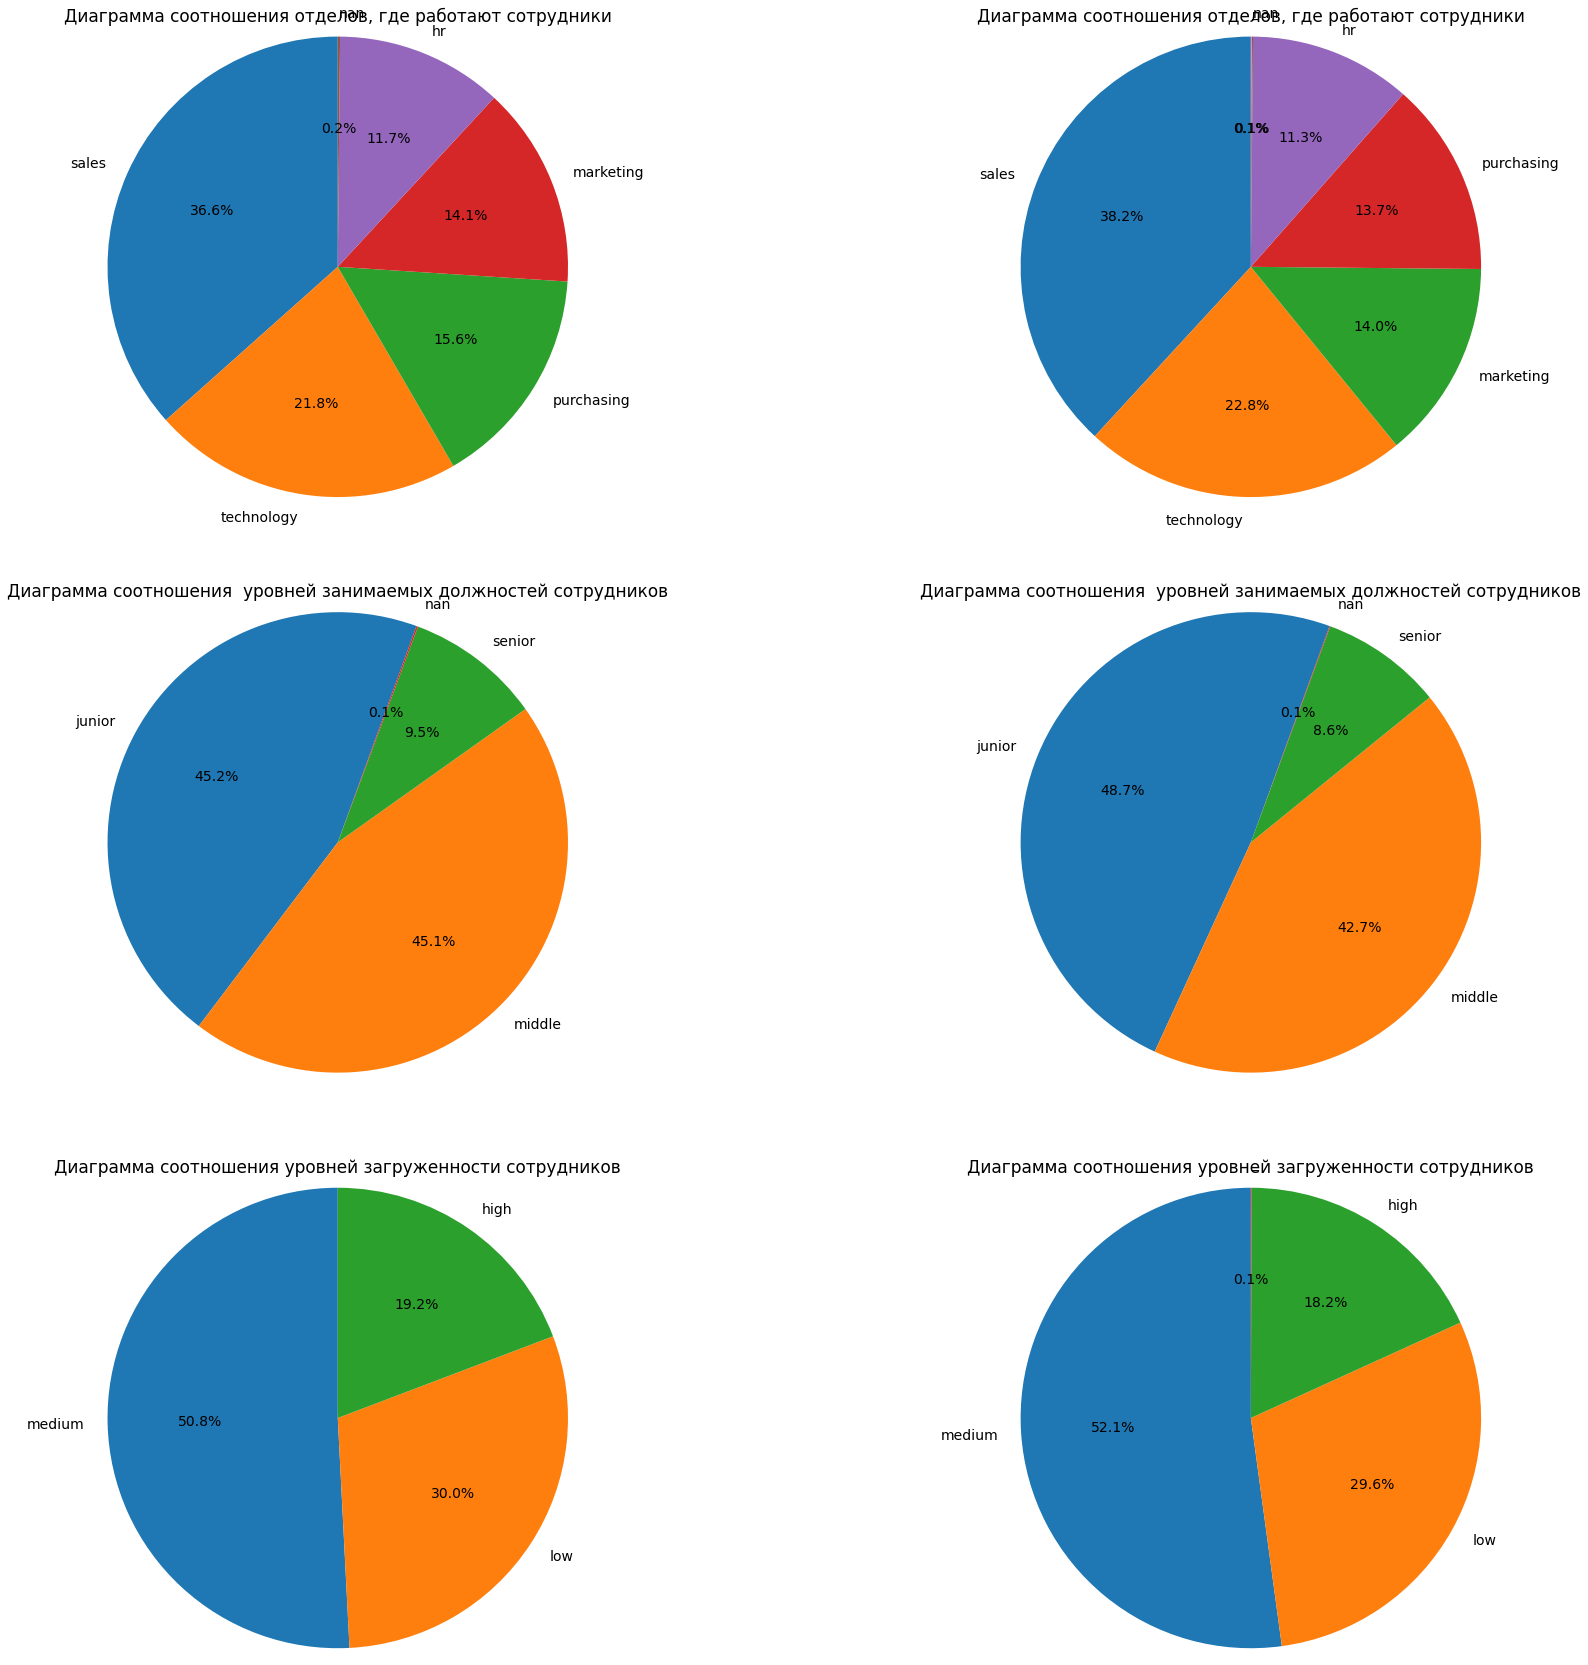

In [47]:
fig,axes = plt.subplots(3,2, figsize=(30,30))
pie(train_job_st['dept'], 'отделов, где работают сотрудники', 90, axes[0,0])
pie(test_features['dept'], 'отделов, где работают сотрудники', 90, axes[0,1])
pie(train_job_st['level'], ' уровней занимаемых должностей сотрудников', 70, axes[1,0])
pie(test_features['level'], ' уровней занимаемых должностей сотрудников', 70, axes[1,1])
pie(train_job_st['workload'], 'уровней загруженности сотрудников', 90, axes[2,0])
pie(test_features['workload'], 'уровней загруженности сотрудников', 90, axes[2,1])

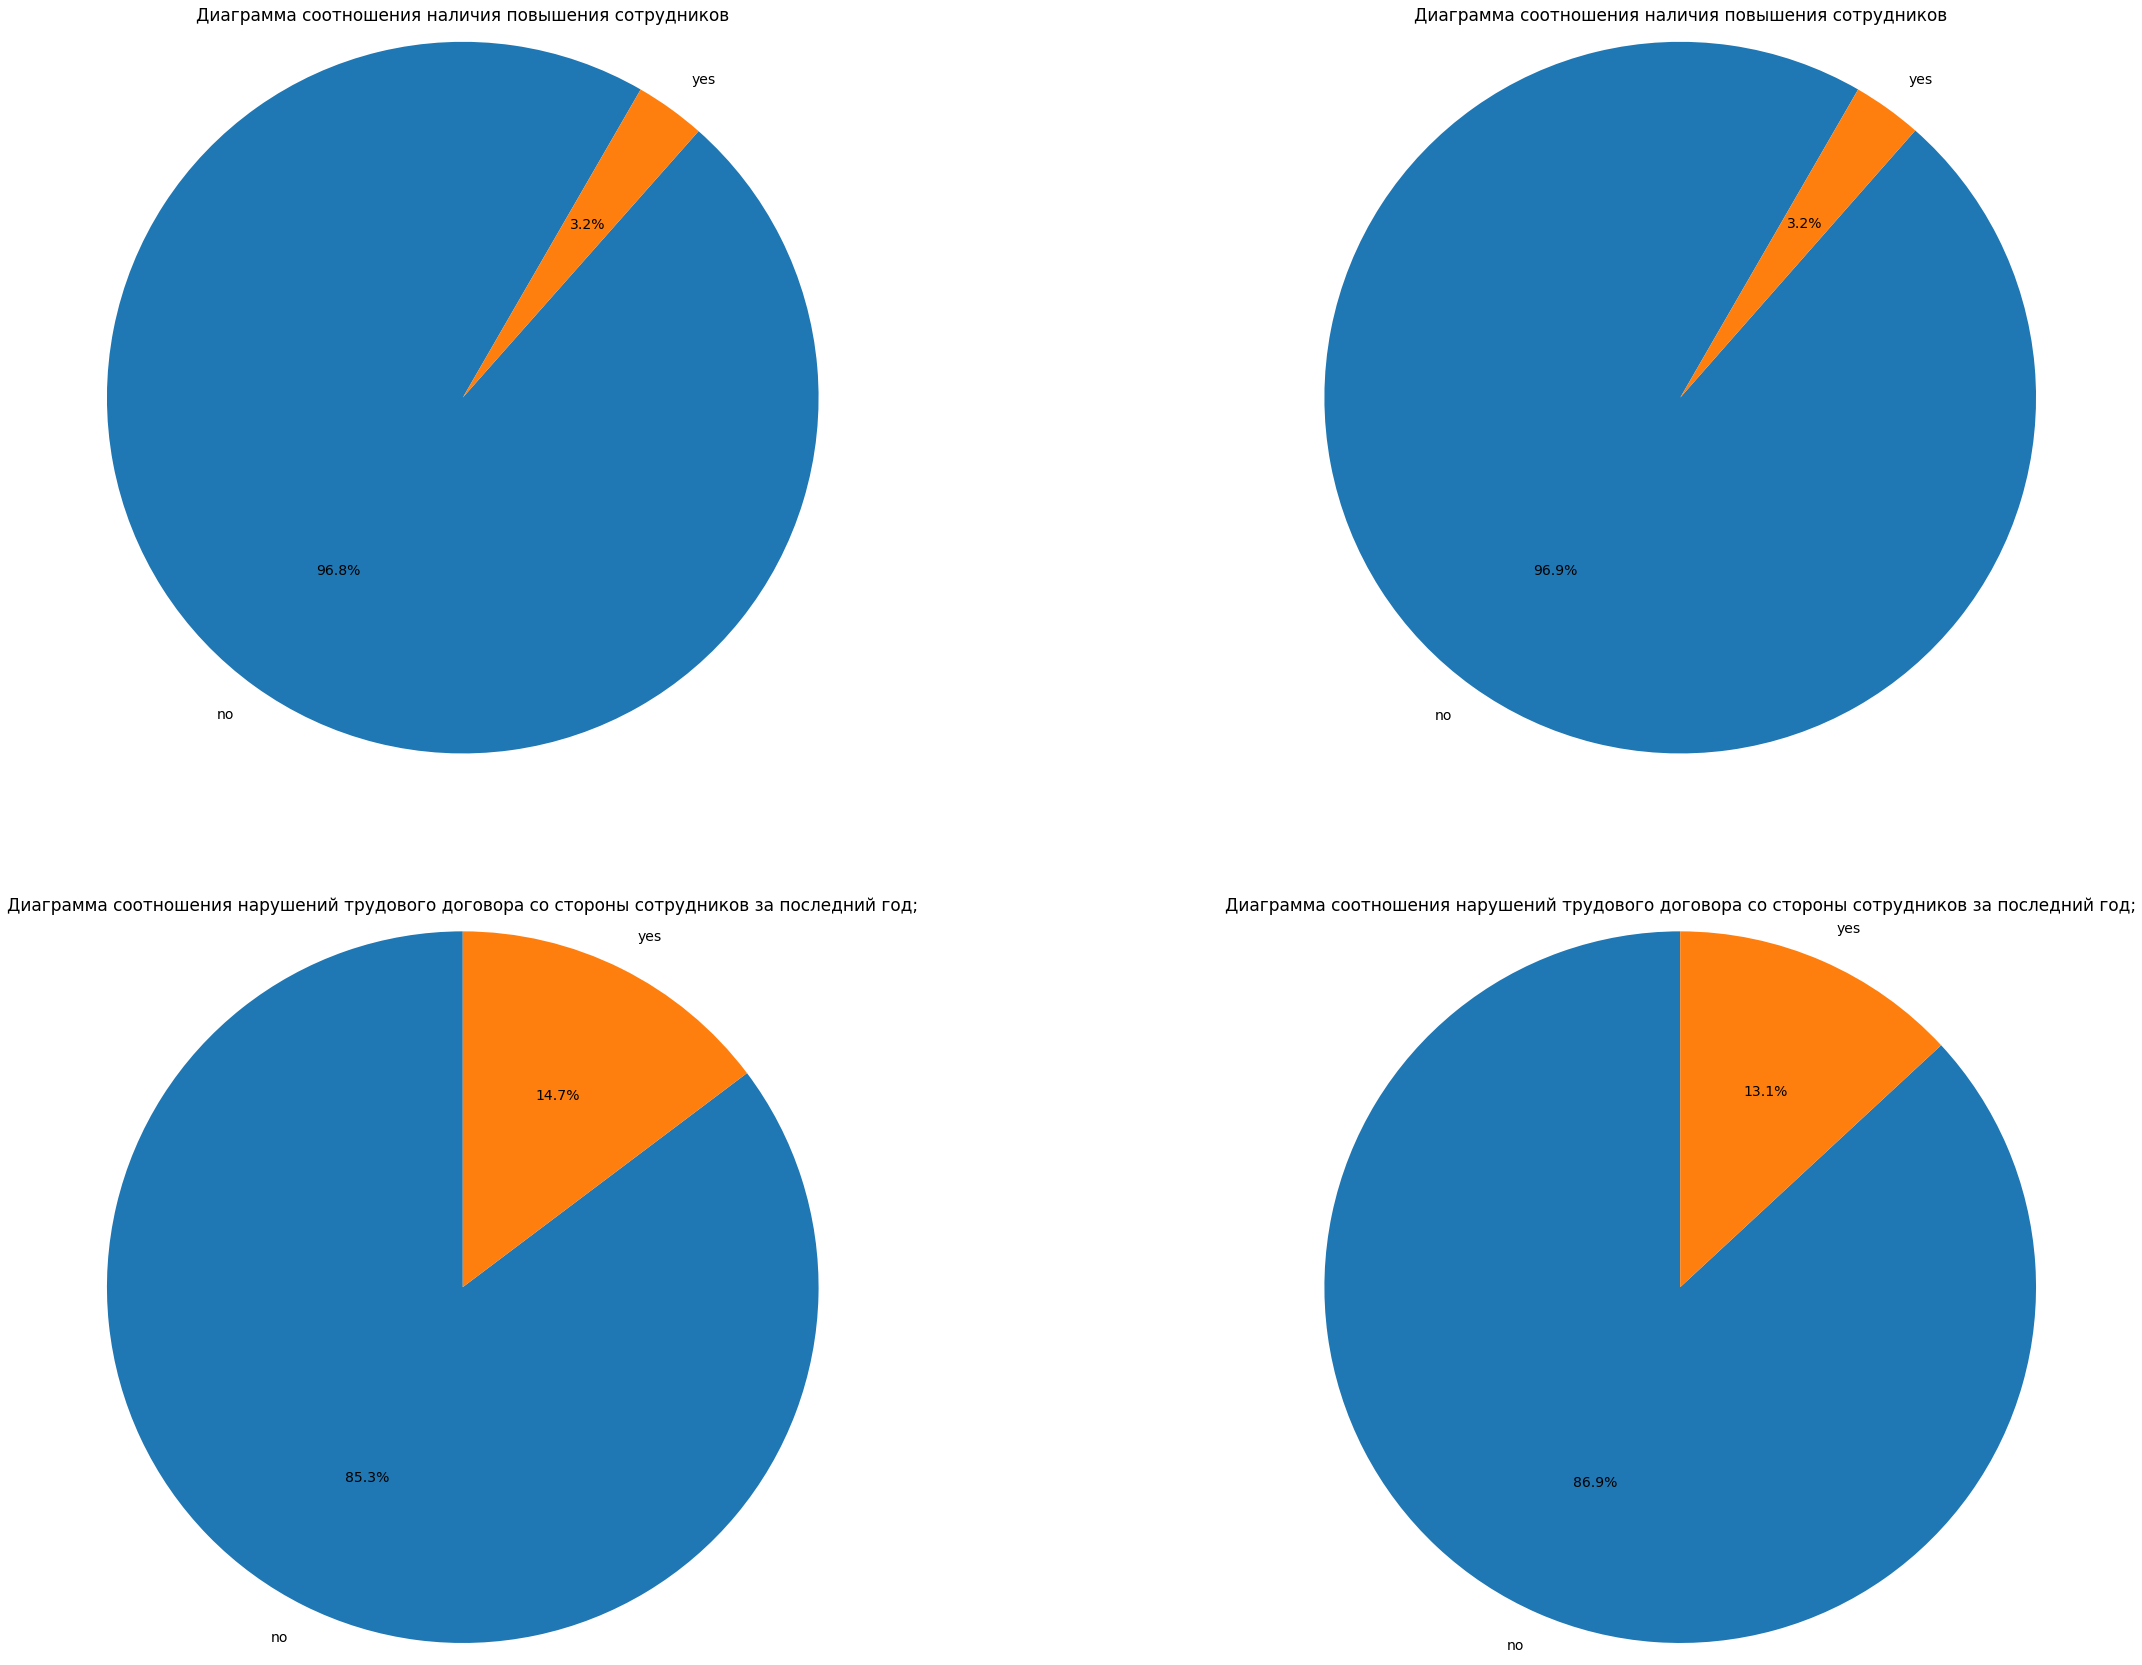

In [48]:
fig,axes = plt.subplots(2,2, figsize=(40,30))
pie(train_job_st['last_year_promo'], 'наличия повышения сотрудников', 60, axes[0,0])
pie(test_features['last_year_promo'], 'наличия повышения сотрудников', 60, axes[0,1])
pie(train_job_st['last_year_violations'], 
    'нарушений трудового договора со стороны сотрудников за последний год;', 90, axes[1,0])
pie(test_features['last_year_violations'], 
    'нарушений трудового договора со стороны сотрудников за последний год;', 90, axes[1,1])

**Dept**: преобладает доля сотрудников из отдела **technology** и **sales** = ~38% и ~22; hr, marketing и purchasing занимают почти одинаковые позиции.

**level**: интересно, что **junior (~47%)** и **middle (~436%)** имеют практически равные доли.

**workload**: по долям уровня загруженности сотрудника лидирует **medium (~51%)**. **low (~30%)**, а **high (~18%)**. В принципе, ситуация вполне себе реалистичная.

**last_year_promo**: двигались по карьерной лестнице всего 3% сотрудников. В компании не любят повышать сотрудников.

**last_year_violations**: Видим, что 14% всех сотрудников нарушали условия трудовых договоров за последний год. Довольно-таки большое значение. Интересно, с чем могло бы быть связано.

**Ситуация по распределению категориальных данных в тренировочной и тестовой выборках практически идентичны, выборки хорошо разделены**

### Анализ количественных данных в таблицах

In [49]:
train_job_st_col = train_job_st.select_dtypes(include='number').columns.to_list()
train_job_st_col.remove('id')
print(train_job_st_col)

['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


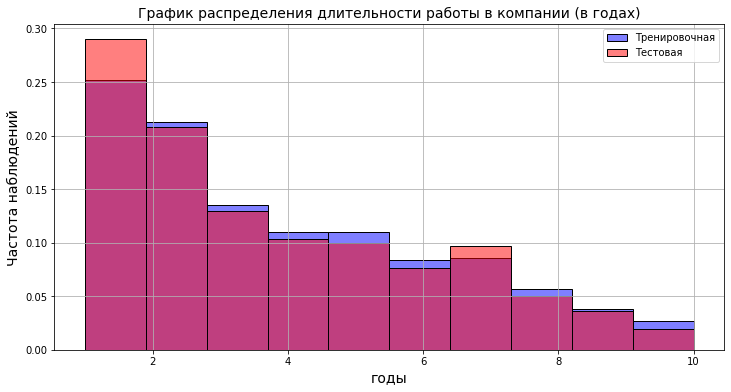

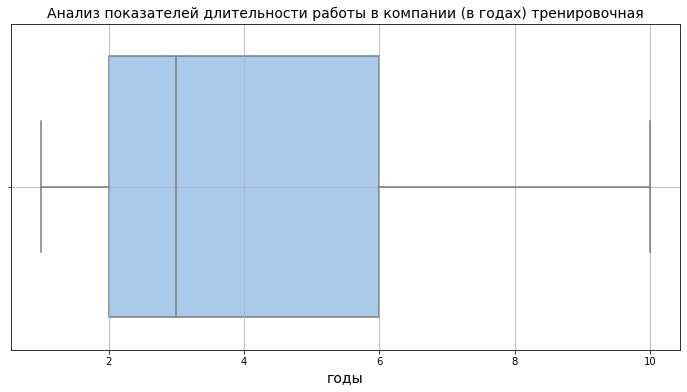

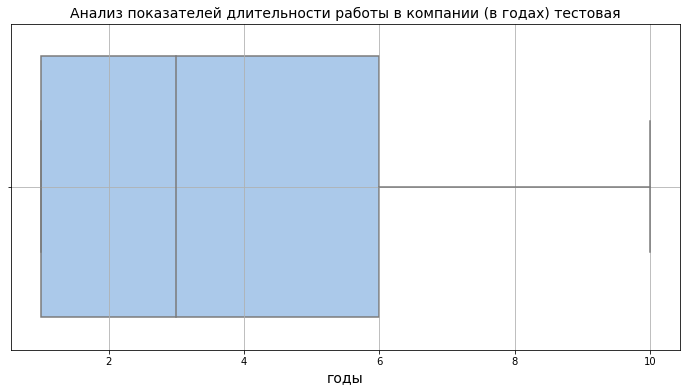

In [50]:
hist(train_job_st, test_features, 'employment_years', 10, 'длительности работы в компании (в годах)', 'годы')
box(train_job_st, 'employment_years', 'длительности работы в компании (в годах) тренировочная', 'годы')
box(test_features, 'employment_years', 'длительности работы в компании (в годах) тестовая', 'годы')

**Выбросов нет, распределение нормальное со смещением влево, чаще всего сотрудники работают в компании от 1 до 3 лет. Нормой для распределения считается промежуток от 2 до 6 лет. В компании много новых сотрудников, возможные причины: недавно произошло слияние с другой компанией или довольно сильная текучка кадров. Распределения в тренировочной и тестовой выборках повторяют друг друга.**

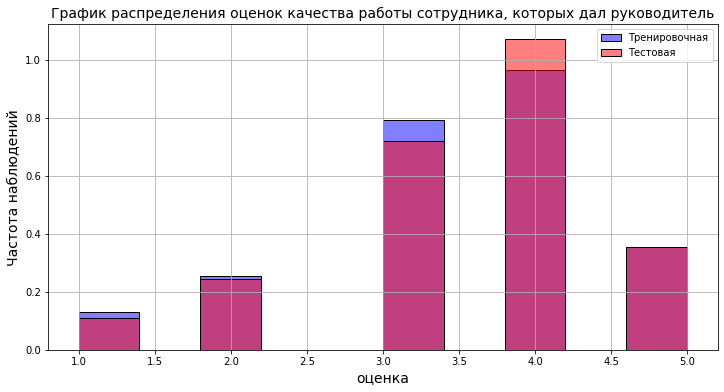

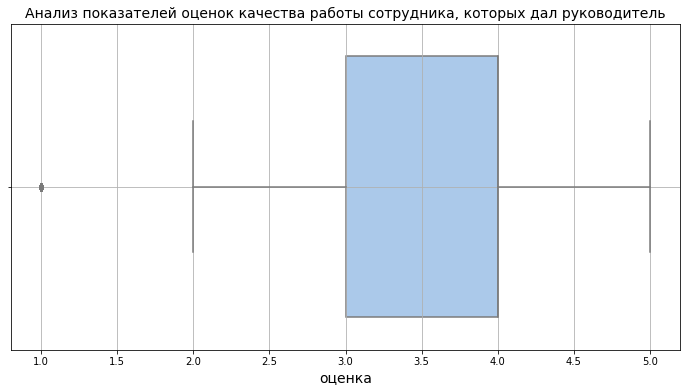

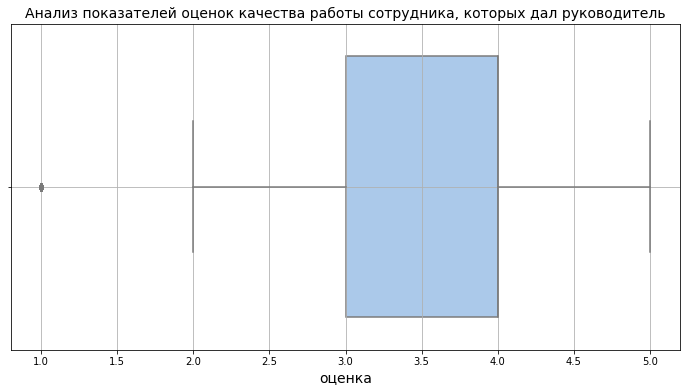

In [51]:
hist(train_job_st, test_features, 'supervisor_evaluation', 10, 'оценок качества работы сотрудника, которых дал руководитель', 'оценка')
box(train_job_st, 'supervisor_evaluation', 'оценок качества работы сотрудника, которых дал руководитель', 'оценка')
box(test_features, 'supervisor_evaluation', 'оценок качества работы сотрудника, которых дал руководитель', 'оценка')

**Распределение нормальное. Чаще всего руководители присваювают оценку 3 или 4. Согласно графику размаха видим, что значение оценки 1 является выбросом. Удалять я его не буду, поскольку таких оценок довольно много и такое может быть в реальности. В целом, картина-то не очень позитивная, можно сказать, что руководители не совсем довольны общим качеством работы подопечных. Распределения в тренировочной и тестовой выборках повторяют друг друга.**

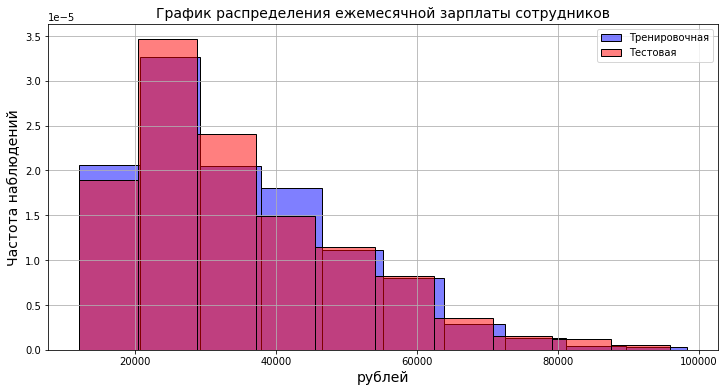

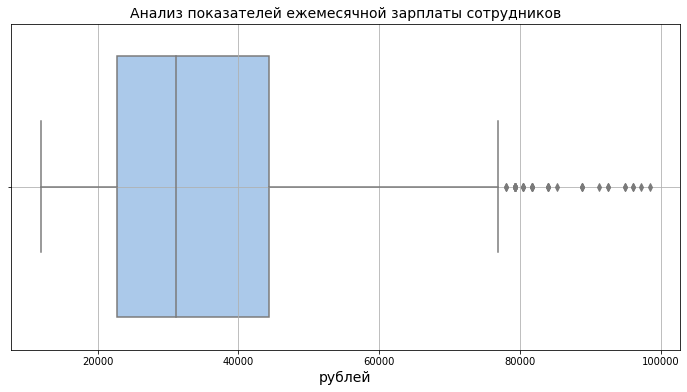

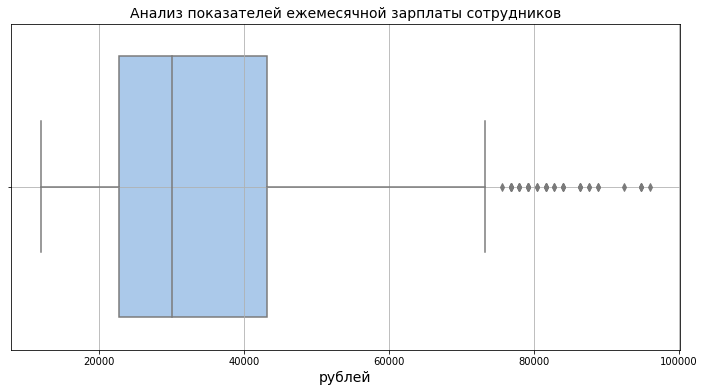

In [52]:
hist(train_job_st, test_features, 'salary', 10, 'ежемесячной зарплаты сотрудников', 'рублей')
box(train_job_st, 'salary', 'ежемесячной зарплаты сотрудников', 'рублей')
box(test_features, 'salary', 'ежемесячной зарплаты сотрудников', 'рублей')

**Распределение нормальное. Самая частая зарплата в районе 30000руб., на графике размаха отмечают выбросы после 70000руб. Довольно сильная разница между уровнями з/п обычных работников и управляющего персонала - стандартная ситуация практически в любой компании. Распределения в тренировочной и тестовой выборках повторяют друг друга.**

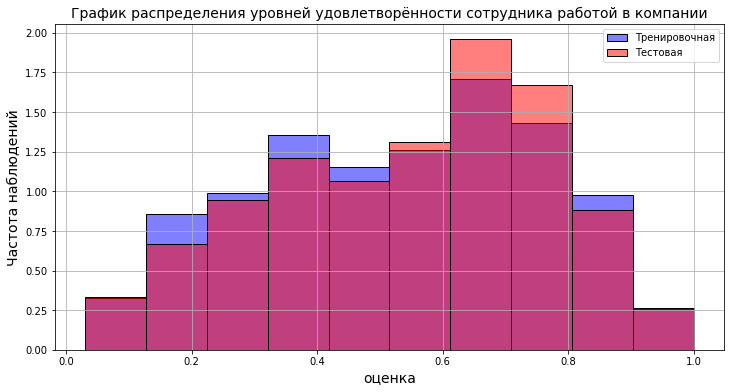

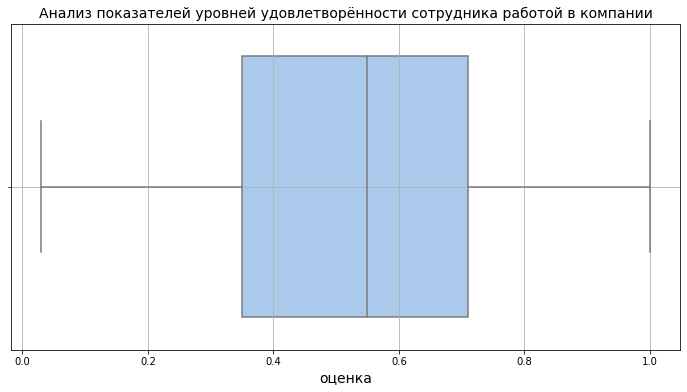

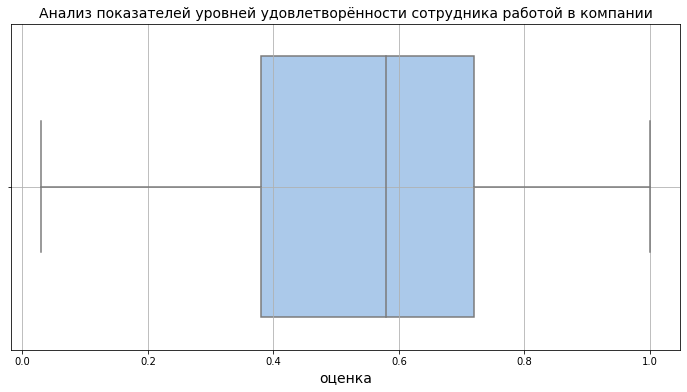

In [53]:
hist(train_job_st, test_target_job_st, 'job_satisfaction_rate', 10, 'уровней удовлетворённости сотрудника работой в компании', 'оценка')
box(train_job_st, 'job_satisfaction_rate', 'уровней удовлетворённости сотрудника работой в компании', 'оценка')
box(test_target_job_st, 'job_satisfaction_rate', 'уровней удовлетворённости сотрудника работой в компании', 'оценка')

**Распределение нормальное, выбросов нет. Больше сотрудников скорее довольны работой, но тогда откуда такая ситуация с текучкой... Будем смотреть в корреляционном анализе. Распределения в тренировочной и тестовой выборках повторяют друг друга.**

Количество сотрудников, которые скорее довольны своей работой в компании 2146
Количество сотрудников, которые скорее НЕ довольны своей работой в компании 1609


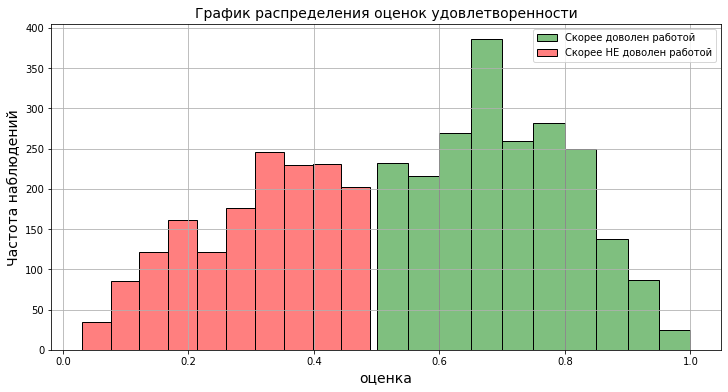

In [54]:
vse_fine = train_job_st.loc[train_job_st['job_satisfaction_rate'] >= 0.5, ['job_satisfaction_rate']].copy()
vse_bad = train_job_st.loc[train_job_st['job_satisfaction_rate'] < 0.5, ['job_satisfaction_rate']].copy()

print('Количество сотрудников, которые скорее довольны своей работой в компании', len(vse_fine))
print('Количество сотрудников, которые скорее НЕ довольны своей работой в компании', len(vse_bad))

plt.figure(figsize=(12,6))
sns.histplot(data=vse_fine['job_satisfaction_rate'], bins=10, alpha=0.5, color='green', label='Скорее доволен работой')
sns.histplot(data=vse_bad['job_satisfaction_rate'], bins=10, alpha=0.5, color='red', label='Скорее НЕ доволен работой')
plt.title(f'График распределения оценок удовлетворенности', fontsize=14)
plt.xlabel(f'оценка', fontsize=14)
plt.ylabel('Частота наблюдений', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

Если представить оценки больше и меньше 0.5 как условную классификацию **Скорее доволен** и **Скорее не доволен**, то видим, что соотношение сотрудников практически 50/50. Такая атмосфера будет совершенно неблаготворно влиять на текучку кадров. Будем выяснять какие факторы влияют на удовлетворенность сотрудников своей работой, чтобы дать компании рекомендации по улучшению социального климата работников.

### Итог раздела:
- **Рассмотрел и описал распределение признаков всех таблиц;**
- **В компании преобладают недавно устроенные сотрудники, которые работают от 1 до 3х лет;**
- **В компании не практикуют частое повышение сотрудников. Все 3% персонала продвинулись по карьерной лестнице за последний год;**
- **Если представить оценки больше и меньше 0.5 как условную классификацию Скорее доволен и Скорее не доволен, то видим, что соотношение сотрудников практически 50/50, что плохо характеризует социальный климат в компании и сильно влияет на увеличение текучести кадров.**

**Портрет обычного сотрудника компании: скорее из отдела sales или technology, на должности junior или middle, загруженность средняя или низкая, без повышения или нарушений трудового договора, работает в компании от 1 до 3х лет, с оценкой от руководителя 3-4 балла, зарплатой 20-50 ты.руб.**

## Задача 1: Корреляционный анализ данных

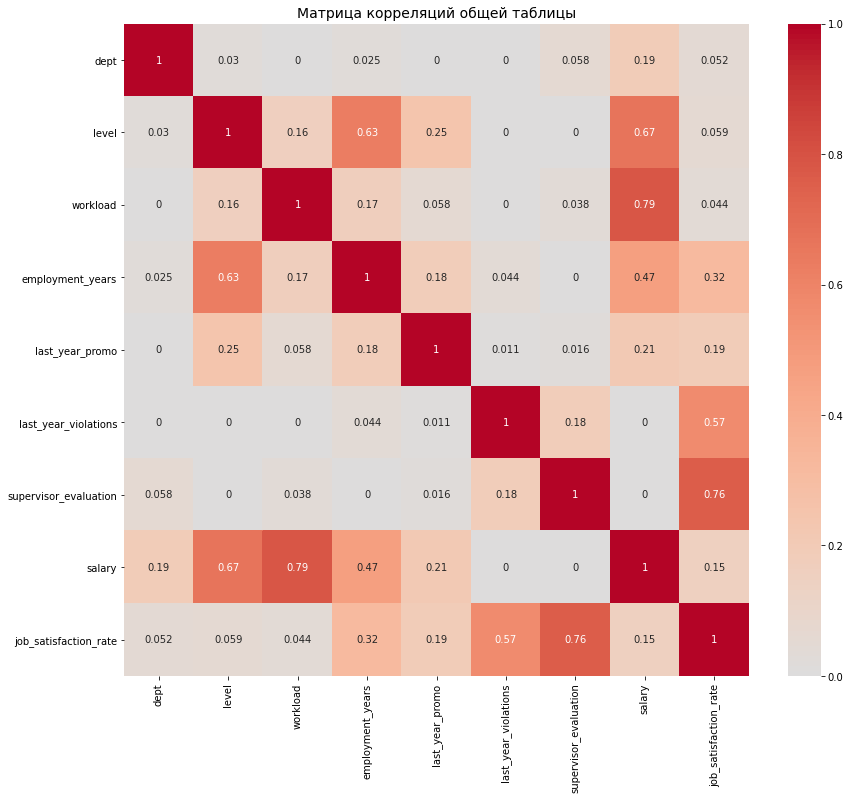

In [55]:
phik_col = train_job_st_col
corr_data = train_job_st.drop('id', axis=1).copy()
corr = corr_data.phik_matrix(interval_cols=phik_col)

plt.figure(figsize=(14,12))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций общей таблицы', fontsize=14)
plt.show()

**Согласно полученным данным наш Целевой признак (job_satisfaction_rate) оказывают влияние следубщие признаки:**
- Сильная зависимость с **supervisor_evaluation** (оценка руководителя) = 0.76
- Заметная зависимость с **last_year_violations** = 0.56
- Слабая зависимость с **employment_years** = 0.33
- Зависимость с **last_year_promo** (0.19) и **salary** (0.17) совсем низкая, что довольно странно

**Мы наблюдаем зависимости между самими признаками:**
- между workload и salary (0.79) (выше уровень загруженности = выше зарплата)
- между level и salary (0.72) (выше должность = выше зарплата)
- между level и employment_years (0.68) (больше стаж работы в компании = выше занимаемая должность)
- между employment_years и salary (0.48) (больше стаж работы в компании = выше зарплата, но это вытекает из зависимости с занимаемой должностью)

In [56]:
def scatter(feature_first,feature_second):
    plt.figure(figsize=(12,8))
    sns.scatterplot(data=scatter_data, x=feature_first, y=feature_second, 
                    alpha=0.3, color='green', hue='job_satisfaction_class', palette = ['orange', 'blue'])
    plt.title(f'График распределения признаков относительно целевого', fontsize=14)
    plt.xlabel(f'{feature_first}', fontsize=14)
    plt.ylabel(f'{feature_second}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
scatter_data = corr_data.copy()
scatter_data['job_satisfaction_class'] = pd.qcut(scatter_data['job_satisfaction_rate'],
                                              q=2,
                                              labels=['скорее не доволен', 'скорее доволен'])
    
scatter_list = corr_data.columns.to_list()
scatter_list.remove('job_satisfaction_rate')
scatter_list

['dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary']

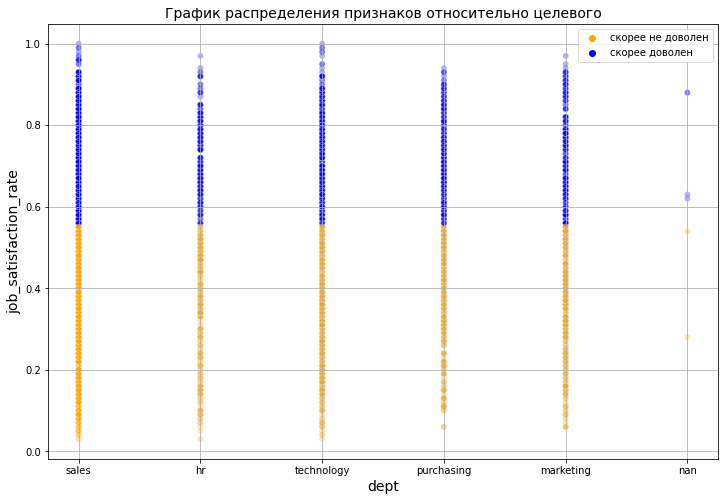

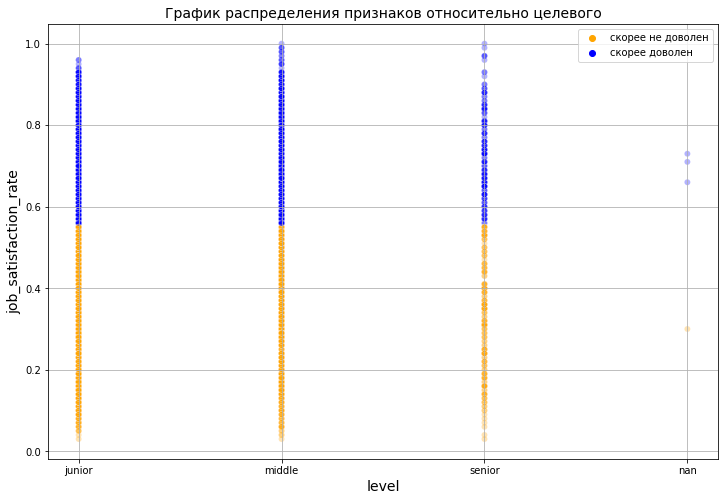

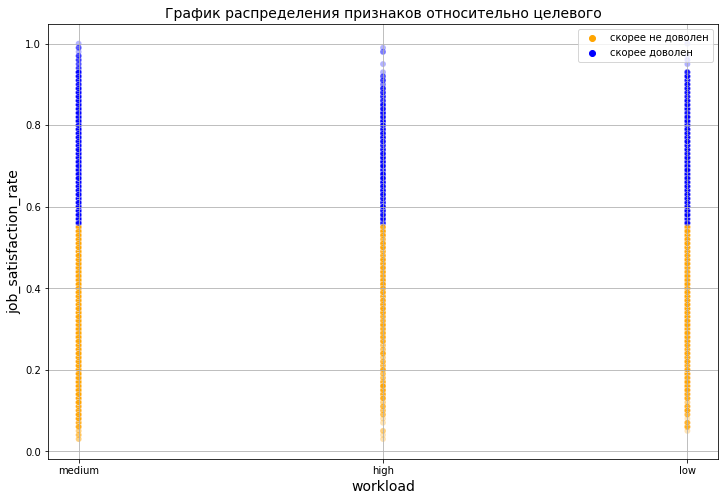

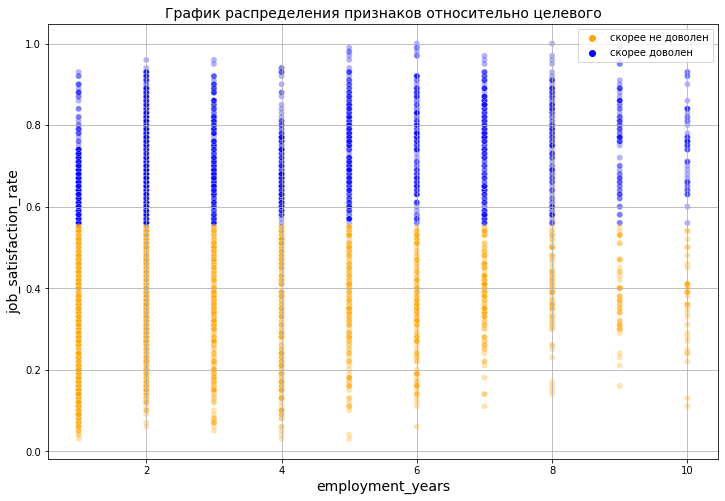

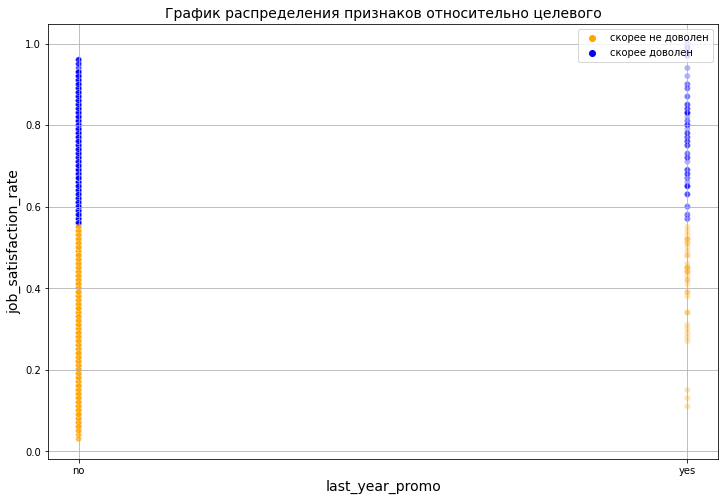

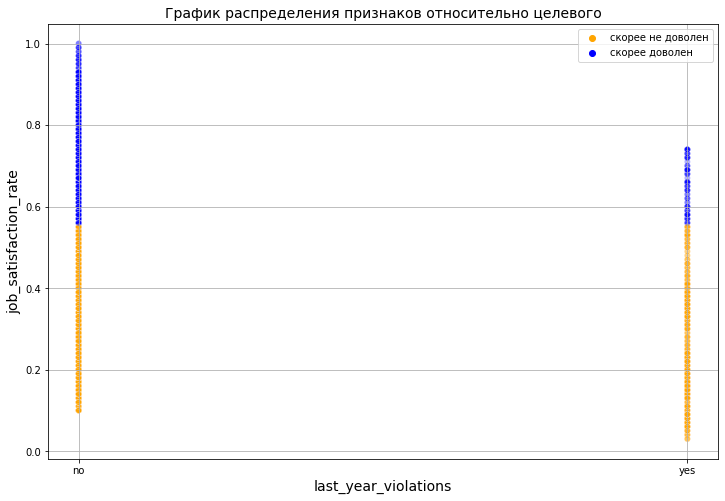

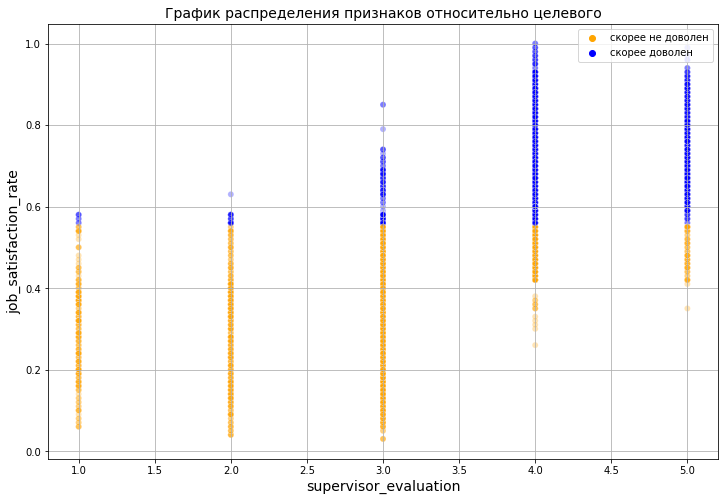

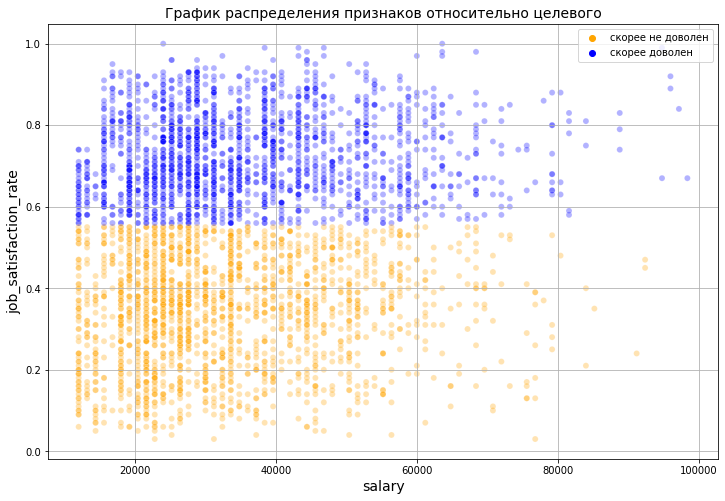

In [57]:
for i in scatter_list:
    scatter(i, 'job_satisfaction_rate')

На графике **job_satisfaction_rate и dept:**
По плотности распределения точек, мы видим, что больше всего недовольных сотредников из отдела technology, sales и marketing.

На графике **job_satisfaction_rate и level:**
В junior и middle недовольных визуально одинаково, но довольных нв middle должности больше.

На графике **job_satisfaction_rate и workload:**
Видим, что загрузка не влияет на степень удовлетворенности работой у сотрудников.

На графике **job_satisfaction_rate и emplotment_years:**
Интересно, что с увеличением срока работы в компании недовольных становится значительно меньше, тогда как довольные остаются практически на том же высоком уровне. Хуже всего социальный климат у новичков.

На графике **job_satisfaction_rate и last_year_promo:**
На графике хорошо видно, что повышение в этом году также не повлияло на степень удовлетворенности сотрудников своей работой.

На графике **job_satisfaction_rate и last_year_violations:**
Тут наблюдаем, что из нарушителей трудового договора большинство как раз недовольных сотрудников.

На графике **job_satisfaction_rate и salary:**
По уровням заработной платы четкого разделения нет. Основная масса сотрудников располагается на промежутке заработной платы от 20 до 40 тыс. руб.

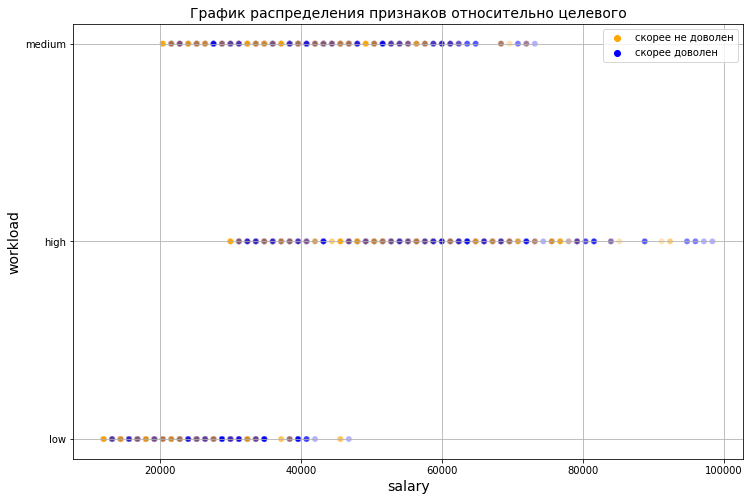

In [58]:
scatter('salary', 'workload')

**При комбинации признаков salary и workload четких разделений не прослеживается. Единственное наблюдение - при высокой загрузке доля недовольных визуально ниже**

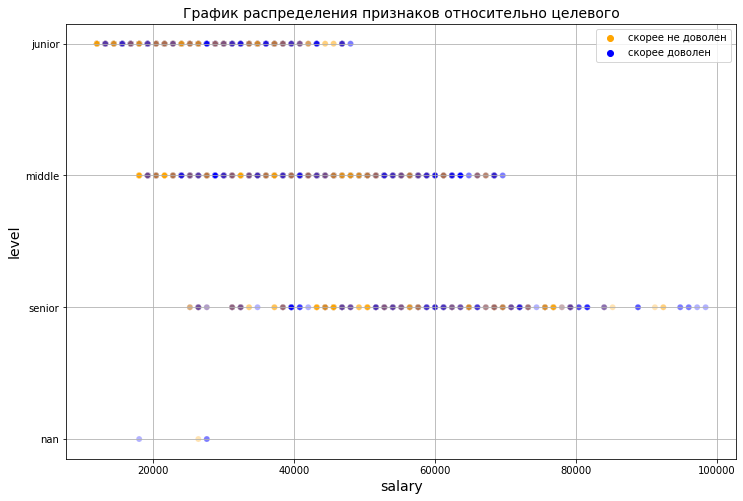

In [59]:
scatter('salary', 'level')

**При рассмотрении level и salary прослеживается некая интересная деталь: на нижних уровнях заработной платы должностей middle и senior как раз сотрудники недовольные работой, думаю что их ожидания при повышении не оправдали себя. Между уровнями з/п нет четкой стратификации, например 40 тыс. руб. может получать и junir, и middle, и senior, при этом уровень нагрузки будет, возможно, разный**

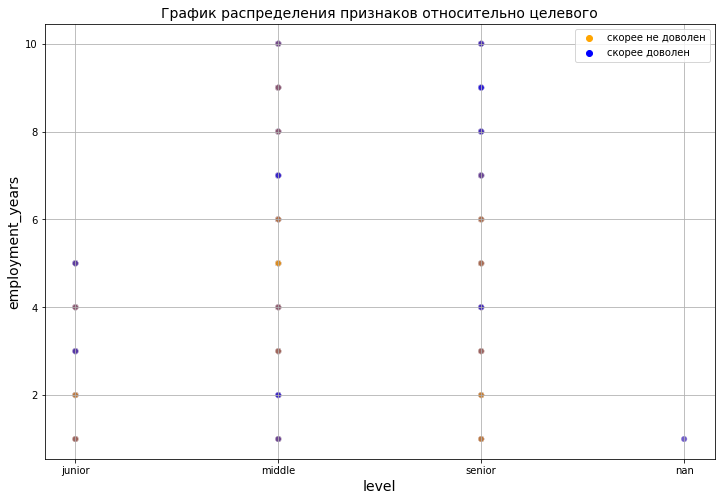

In [60]:
scatter('level', 'employment_years')

**Новички на должности senior скорее не довольны своей работой**

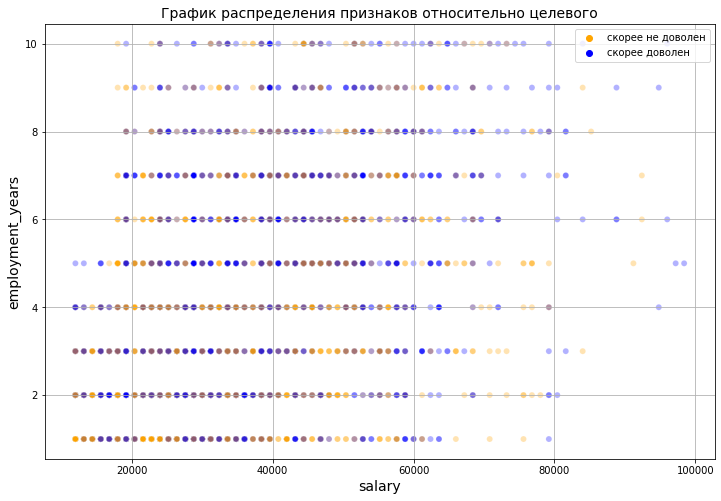

In [61]:
scatter('salary', 'employment_years')

**Здесь четкого разделения не прослеживается, разве что чем дольше в компании - тем выше у тебя зп, но так далеко не всегда**

**Проведу дополнительно тест VIF на мультиколлинеарность, может что-то просмотрел. Значения VIF принято оценивать от 0 до 10, где 0 - нет мультиколлинеарности, 10 - высокая степень мультиколлинеарности**

In [62]:
vif_data = corr_data.select_dtypes(include=['int', 'float', 'bool'])
vif_data = vif_data.assign(const=1)  

quantitative_features = [col for col in vif_data.columns if col != 'const']

vif = pd.DataFrame()
vif['Входной признак'] = quantitative_features
vif['Показатель VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(len(quantitative_features))]
vif = vif.sort_values(by='Показатель VIF', ascending=False)

display(vif)

,Входной признак,Показатель VIF
3,job_satisfaction_rate,2.093695
1,supervisor_evaluation,1.999400
0,employment_years,1.340817
2,salary,1.256009


**Мультиколлинеарность не наблюдается, входных признаков немного, перейдем к построению пайплайна для решения задачи**

### Итог раздела:
- Сильная зависимость с **supervisor_evaluation** (оценка руководителя) = 0.76
- Заметная зависимость с **last_year_violations** = 0.56
- Слабая зависимость с **employment_years** = 0.33
- Зависимость с **last_year_promo** (0.19) и **salary** (0.17) совсем низкая**

**В комппании нет сильного разделения уровней заработной платы согласно занимаемой должности**

**Недовольны своей работой в основном новички на должностях junior и middle с заработной платой от 20 по 40 тыс.руб.**

**По корреляционным зависимостям складывается впечатление, что на уровень удовлетворенности сотрудника своей работой влияет больше всего отношение с руководителем**

## Задача 1: Обучение моделей

### Обработка признаков

In [63]:
test_merged_table = test_features.merge(test_target_job_st, how='left', on='id')

drop_train = train_job_st.select_dtypes(include='number').columns.to_list()
X_1_train = train_job_st[drop_train].copy()
X_1_train = X_1_train.drop(['id','job_satisfaction_rate'], axis=1)
y_1_train = train_job_st['job_satisfaction_rate'].copy()

drop_test = test_features.select_dtypes(include='number').columns.to_list()
X_2_test = test_merged_table[drop_test].copy()
X_2_test = X_2_test.drop('id', axis=1)
y_2_test = test_merged_table['job_satisfaction_rate']

degrees = range(2, 7)


results = {}


for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    
    X_poly_train = poly.fit_transform(X_1_train)
    X_poly_test = poly.transform(X_2_test)
    
    model = LinearRegression()
    model.fit(X_poly_train, y_1_train)
    
    y_pred_train = model.predict(X_poly_train)
    y_pred_test = model.predict(X_poly_test)
    
    r2_train = r2_score(y_1_train, y_pred_train)
    mse_train = mean_squared_error(y_1_train, y_pred_train)
    
    r2_test = r2_score(y_2_test, y_pred_test)
    mse_test = mean_squared_error(y_2_test, y_pred_test)
    
    results[degree] = {
        'R2_train': r2_train,
        'MSE_train': mse_train,
        'R2_test': r2_test,
        'MSE_test': mse_test
    }

for degree, metrics in results.items():
    print(f"Degree {degree}:")
    print(f"  R2_train: {metrics['R2_train']:.4f}")
    print(f"  MSE_train: {metrics['MSE_train']:.4f}")
    print(f"  R2_test: {metrics['R2_test']:.4f}")
    print(f"  MSE_test: {metrics['MSE_test']:.4f}")
    print("-" * 30)

Degree 2:
  R2_train: 0.5395
  MSE_train: 0.0236
  R2_test: 0.5451
  MSE_test: 0.0220
------------------------------
Degree 3:
  R2_train: 0.6422
  MSE_train: 0.0183
  R2_test: 0.6465
  MSE_test: 0.0171
------------------------------
Degree 4:
  R2_train: 0.5861
  MSE_train: 0.0212
  R2_test: 0.5947
  MSE_test: 0.0196
------------------------------
Degree 5:
  R2_train: 0.5507
  MSE_train: 0.0230
  R2_test: 0.5447
  MSE_test: 0.0220
------------------------------
Degree 6:
  R2_train: 0.4676
  MSE_train: 0.0273
  R2_test: 0.4098
  MSE_test: 0.0286
------------------------------


**По результатам получаем, что модель сильно переобучается на тренировочной выборке. В результате я взял полиномы 3ей степени количественных признаков + перемноженный стаж работы на заработную плату, что увеличило метрику, что благотворно повлияло на метрику задачи.**

In [65]:
X_train = train_job_st.drop(['id','job_satisfaction_rate'], axis=1).copy()
X_train['salary^3'] = X_train['salary'] ** 3
X_train['supervisor_evaluation^3'] = X_train['supervisor_evaluation'] ** 3
X_train['employment_years^3'] = X_train['employment_years'] ** 3
X_train['employment_x_salary'] = X_train['employment_years'] * X_train['salary']
y_train = train_job_st['job_satisfaction_rate'].copy()

X_test = test_merged_table.drop(['id','job_satisfaction_rate'], axis=1).copy()
X_test['salary^3'] = X_test['salary'] ** 3
X_test['supervisor_evaluation^3'] = X_test['supervisor_evaluation'] ** 3
X_test['employment_years^3'] = X_test['employment_years'] ** 3
X_test['employment_x_salary'] = X_test['employment_years'] * X_test['salary']
y_test = test_merged_table['job_satisfaction_rate']

### Построение пайплайна

***Посмотрите пожалуйста мое тестовое решение на Optuna, поскольку в теории не было дано примера подобного поисковика, мне пришлось тащить знания отовсюду. Хочу, чтобы у меня был понятный и удобный шаблон на будущее. Может вы сможете как-то его модернизировать?***

**Создаем пайплайн и с помощью Optuna и GridSearch() ищем лучшую модель и ее параметры для нашей задачи.**

In [66]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_result = np.mean(numerator / denominator) * 100
    return smape_result

def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['DecisionTree', 'LinearRegression'])
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'passthrough'])
    
    ohe_columns = X_train.select_dtypes(exclude='number').columns.to_list()
    num_columns = X_train.select_dtypes(include='number').columns.to_list()
    
    ohe_pipe = Pipeline([
        ('simpleImputerOhe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ])
    
    if scaler_type == 'StandardScaler':
        num_transformer = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        num_transformer = MinMaxScaler()
    else:
        num_transformer = 'passthrough'
    
    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('num', num_transformer, num_columns)
        ]
    )
    
    if model_type == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 5, 10)
        model = DecisionTreeRegressor(
            random_state=r_s, 
            max_depth=max_depth, 
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split
        )
    else:
        model = LinearRegression()
    
    pipeline = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('model', model)
        ]
    )
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_train)
    
    return smape(y_train, y_pred)

r_s = 42


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print(f'  Value (SMAPE): {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

best_model_type = trial.params.get('model_type')
best_scaler_type = trial.params.get('scaler_type')

ohe_columns = ['last_year_promo', 'last_year_violations', 'workload', 'level', 'dept']
num_columns = X_train.select_dtypes(include='number').columns.to_list()

ohe_pipe = Pipeline([
    ('simpleImputerOhe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])


if best_scaler_type == 'StandardScaler':
    num_transformer = StandardScaler()
elif best_scaler_type == 'MinMaxScaler':
    num_transformer = MinMaxScaler()
else:
    num_transformer = 'passthrough'


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_transformer, num_columns)
    ]
)


if best_model_type == 'DecisionTree':
    model = DecisionTreeRegressor(
        random_state=r_s, 
        max_depth=trial.params.get('max_depth'), 
        min_samples_leaf=trial.params.get('min_samples_leaf'),
        min_samples_split=trial.params.get('min_samples_split')
    )
elif best_model_type == 'SVR':
    C = trial.suggest_float('C', 0.1, 10.0, log=True),
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf']),
    model = SVR(C=C, kernel=kernel)
    
elif best_model_type == 'LinearRegression':
    model = LinearRegression()


best_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', model)
    ]
)


best_pipeline.fit(X_train, y_train)


y_pred = best_pipeline.predict(X_test)


test_smape = smape(y_test, y_pred)
print(f'Test SMAPE: {test_smape}')


if test_smape <= 15:
    print("SMAPE на тестовой выборке меньше или равно 15")
else:
    print("SMAPE на тестовой выборке больше 15")

[I 2024-12-16 14:04:29,795] A new study created in memory with name: no-name-5fdfb20e-6964-49a8-b889-89999a25bcf6
[I 2024-12-16 14:04:29,832] Trial 0 finished with value: 22.53202287532471 and parameters: {'model_type': 'DecisionTree', 'scaler_type': 'StandardScaler', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 9}. Best is trial 0 with value: 22.53202287532471.
[I 2024-12-16 14:04:29,930] Trial 1 finished with value: 23.320633425140308 and parameters: {'model_type': 'LinearRegression', 'scaler_type': 'StandardScaler'}. Best is trial 0 with value: 22.53202287532471.
[I 2024-12-16 14:04:30,123] Trial 2 finished with value: 13.921157072832457 and parameters: {'model_type': 'DecisionTree', 'scaler_type': 'passthrough', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 10}. Best is trial 2 with value: 13.921157072832457.
[I 2024-12-16 14:04:30,321] Trial 3 finished with value: 23.32063342514026 and parameters: {'model_type': 'LinearRegression', 'scaler_type': 'Min

Best trial:
  Value (SMAPE): 13.540699873567863
  Params: 
    model_type: DecisionTree
    scaler_type: passthrough
    max_depth: 10
    min_samples_leaf: 5
    min_samples_split: 9
Test SMAPE: 14.908964649852487
SMAPE на тестовой выборке меньше или равно 15


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [78]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_result = np.mean(numerator / denominator) * 100
    return smape_result

smape_scorer = make_scorer(smape, greater_is_better=False)

r_s = 42

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = X_train.select_dtypes(include='number').columns.to_list()


ohe_pipe = Pipeline(
    [
        ('simpleImputerOhe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputerBeforeOrd', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
        categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ],
        handle_unknown='use_encoded_value', unknown_value=np.nan
        )),
        ('simpleImputerAfterOrd', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ]
)

param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=r_s)],
        'model__max_depth': range(2,10),
        'model__min_samples_leaf': range(2,10),
        'model__min_samples_split': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring = smape_scorer,
    n_jobs = -1,
    cv = 5 

)


grid_search.fit(X_train,y_train)

print('SMAPE для лучшей модели:\n', -grid_search.best_score_)
print('\nЛучшая модель и ее параметры:\n\n', grid_search.best_estimator_)

y_pred_gs = grid_search.best_estimator_.predict(X_test)
test_smape = smape(y_test, y_pred_gs)
print(f'Test SMAPE: {test_smape}')

if test_smape <= 15:
    print("SMAPE на тестовой выборке меньше или равно 15")
else:
    print("SMAPE на тестовой выборке больше 15")

SMAPE для лучшей модели:
 17.122581764766938

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputerOhe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                               

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Grid сработал слишком медленно и при заданном количестве кросс-валидаций выдал тестовую метрику меньше, чем на Оптуне.**

**Лучшая модель DecisionTree( scaler_type: MinMaxScaler, max_depth: 10, min_samples_leaf: 5, min_samples_split: 9),
с лучшей метрикой на тестовой выборке SMAPE: 14.90. Это говорит о том, что модель хорошо предсказывает целевой признак**

### Оценка важности признаков для модели и интерпретация методом SHAP


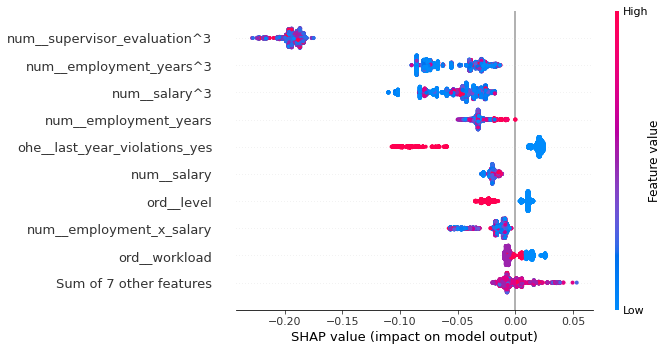

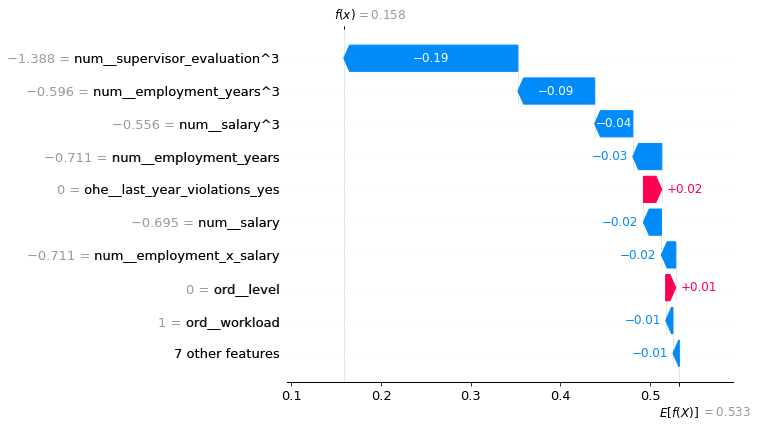

In [79]:
true_model = grid_search.best_estimator_.named_steps['model']

# Извлечение preprocessed данных 
X_train_preprocessed = data_preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(
    X_train_preprocessed, 
    columns=data_preprocessor.get_feature_names_out()
)

# Создание explainer 
explainer_true = shap.TreeExplainer(true_model)
shap_values = explainer_true(X_train_preprocessed)

# Визуализация
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[0])

In [80]:
y_pred[0]

0.8284745762711863

**Видим, что на предсказание модели больше всего влияют:**

supervisor_evaluation^3 - чем выше оценка руководителя -> тем выше уровень удовлетворенности работой у сотрудника;

employment_years^3 - чем меньше лет проработал -> скорее будет более недовольным своей работой;

salary^3 - чем ниже зп -> сотрудник скорее будет более недовольным своей работой;

last_year_violations - если нет нарушений трудового договора, модель склоняется назначить повышенную оценку удовлетворенности

level - чем ниже должность, тем выше шансы на увольнение

**Так для строки №1 модель выставила высокую оценку удовлетворенности своей работой 0.83, где самым весомым фактором стала оценка руководителя и срок службы сотрудника, а также отстутствие понижающих важных признаков.**

## Оформление выводов

**Провел обработку входных признаков и добавил новые, но значение метрики на тестовой выборке все равно низкое. Остается увеличивать выборку, либо добавлять новые признаки в исходную таблицу, которые будут более точно описывать целевой признак удовлетворенности работой у сотрудников**

**Модель Decision Tree справилась лучше, потому что она многоуровневая и способна к обработке категориальных признаков. Также замечает не только линейные зависимости.**

**Важнее всех для предсказаний модели являются признаки: supervisor_evaluation^3, employment_years^3, salary^3, last_year_violations, level. Их значения лучше всего описывают целевой.**

## Задача 2: Загрузка данных

In [81]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

train_quit.name = 'train_quit'
test_target_quit.name = 'test_target_quit'

new_files = [train_quit, test_target_quit]

pd.set_option('display.max_columns', None)

for i in new_files:
    print ('\n', i.name)
    display(i.sample(10))


 train_quit


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
488,242918,sales,junior,low,2,no,no,3,18000,yes
1836,474943,technology,sinior,medium,9,yes,no,3,62400,no
2381,559628,marketing,junior,medium,3,no,no,3,24000,yes
2377,359629,marketing,middle,low,10,no,no,4,31200,no
3816,285915,sales,junior,medium,3,no,no,3,27600,yes
176,913521,sales,junior,medium,1,no,no,4,24000,no
2624,845912,sales,junior,medium,4,no,no,3,21600,no
1991,107777,hr,middle,low,7,no,no,3,25200,no
3645,629528,sales,middle,low,2,no,no,4,28800,no
1955,970707,sales,middle,medium,6,no,no,4,38400,no



 test_target_quit


,id,quit
121,258254,no
430,916041,no
1406,647356,yes
1262,513138,no
675,832342,no
1162,915959,no
1833,879098,no
415,414089,no
560,829025,no
386,637338,no


In [82]:
for i in new_files:
    print('\n', i.name, '\n',)
    display(i.info())


 train_quit 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None


 test_target_quit 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

In [83]:
for i in new_files:
    print('\n', i.name, '\n',)
    display(i.describe())


 train_quit 



,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000



 test_target_quit 



,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


### Выводы:
- **Пропуски отсутствуют;**
- **Аномальные значения отсутствуют;**
- **Нужно проверить на явные и неявные дубликаты.**

## Задача 2: Предобработка данных

In [84]:
# Снова приводим все к нижнему регистру и проверяем на ошибки/опечатки
for i in new_files:
    str_lower(i)
    check_errors(i)

train_quit - dept


sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

train_quit - level


junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

train_quit - workload


medium    2118
low       1208
high       674
Name: workload, dtype: int64

train_quit - last_year_promo


no     3887
yes     113
Name: last_year_promo, dtype: int64

train_quit - last_year_violations


no     3455
yes     545
Name: last_year_violations, dtype: int64

train_quit - quit


no     2872
yes    1128
Name: quit, dtype: int64

test_target_quit - quit


no     1436
yes     564
Name: quit, dtype: int64

In [88]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
train_quit['level'].value_counts()

junior    1949
middle    1694
senior     357
Name: level, dtype: int64

In [92]:
train_quit.duplicated(subset=train_quit.columns[1:]).sum()

0

In [91]:
train_quit = train_quit.drop_duplicates(subset=train_quit.columns[1:], keep='first')

### Итоги раздела:
- **Ошибок не обнаружил**
- **Опечатку в должности исправил**
- **Явные дубликаты устранены в тренировочной выборке**

## Задача 2: Исследовательский анализ

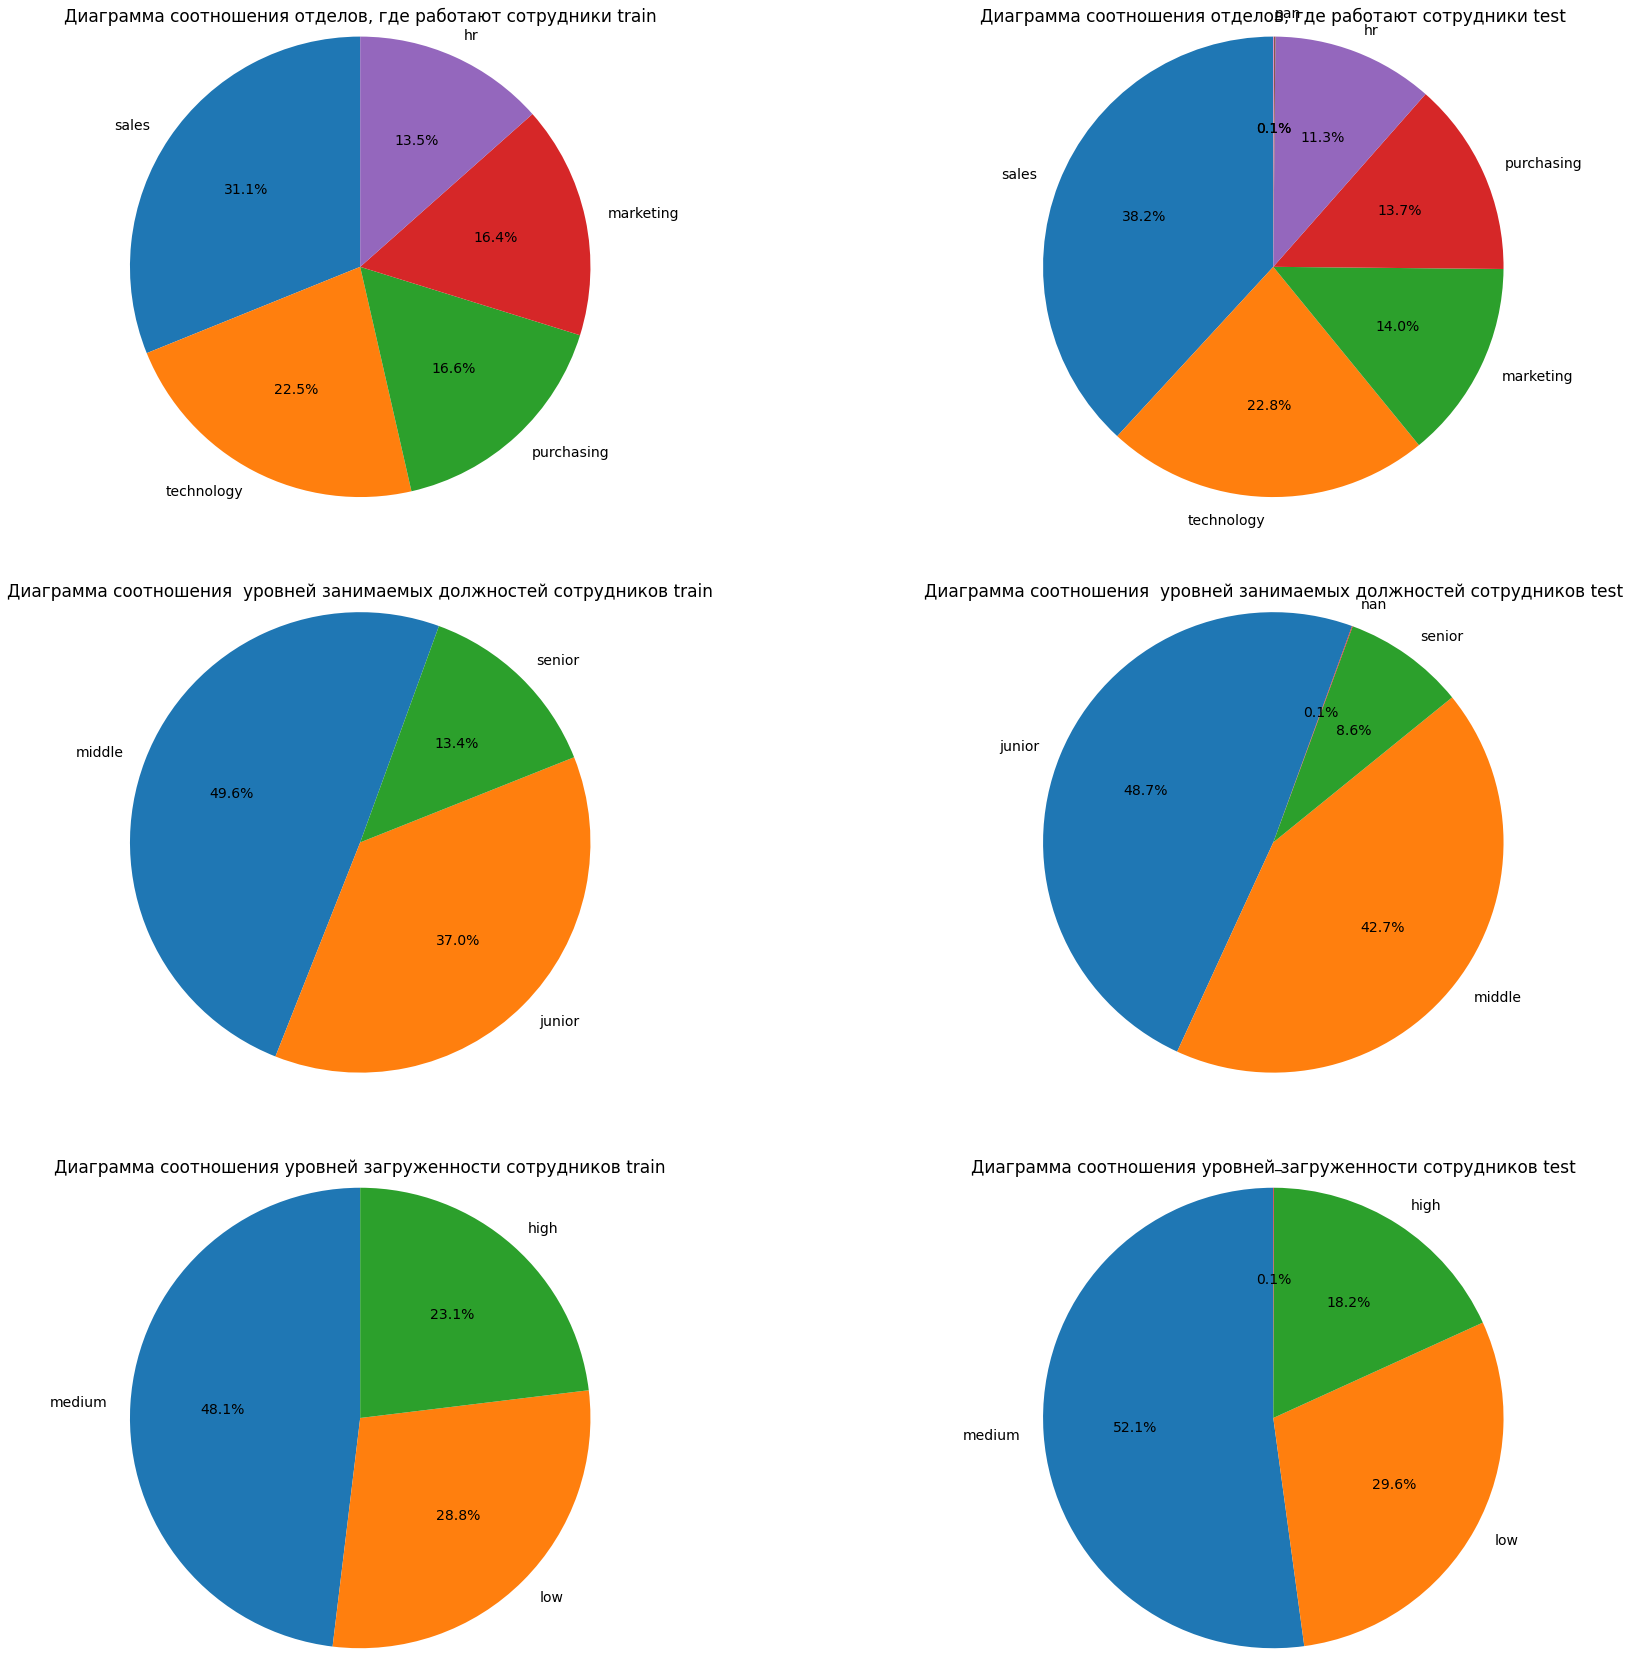

In [93]:
fig,axes = plt.subplots(3,2, figsize=(30,30))
pie(train_quit['dept'], 'отделов, где работают сотрудники train', 90, axes[0,0])
pie(train_quit['level'], ' уровней занимаемых должностей сотрудников train', 70, axes[1,0])
pie(train_quit['workload'], 'уровней загруженности сотрудников train', 90, axes[2,0])
pie(test_features['dept'], 'отделов, где работают сотрудники test', 90, axes[0,1])
pie(test_features['level'], ' уровней занимаемых должностей сотрудников test', 70, axes[1,1])
pie(test_features['workload'], 'уровней загруженности сотрудников test', 90, axes[2,1])

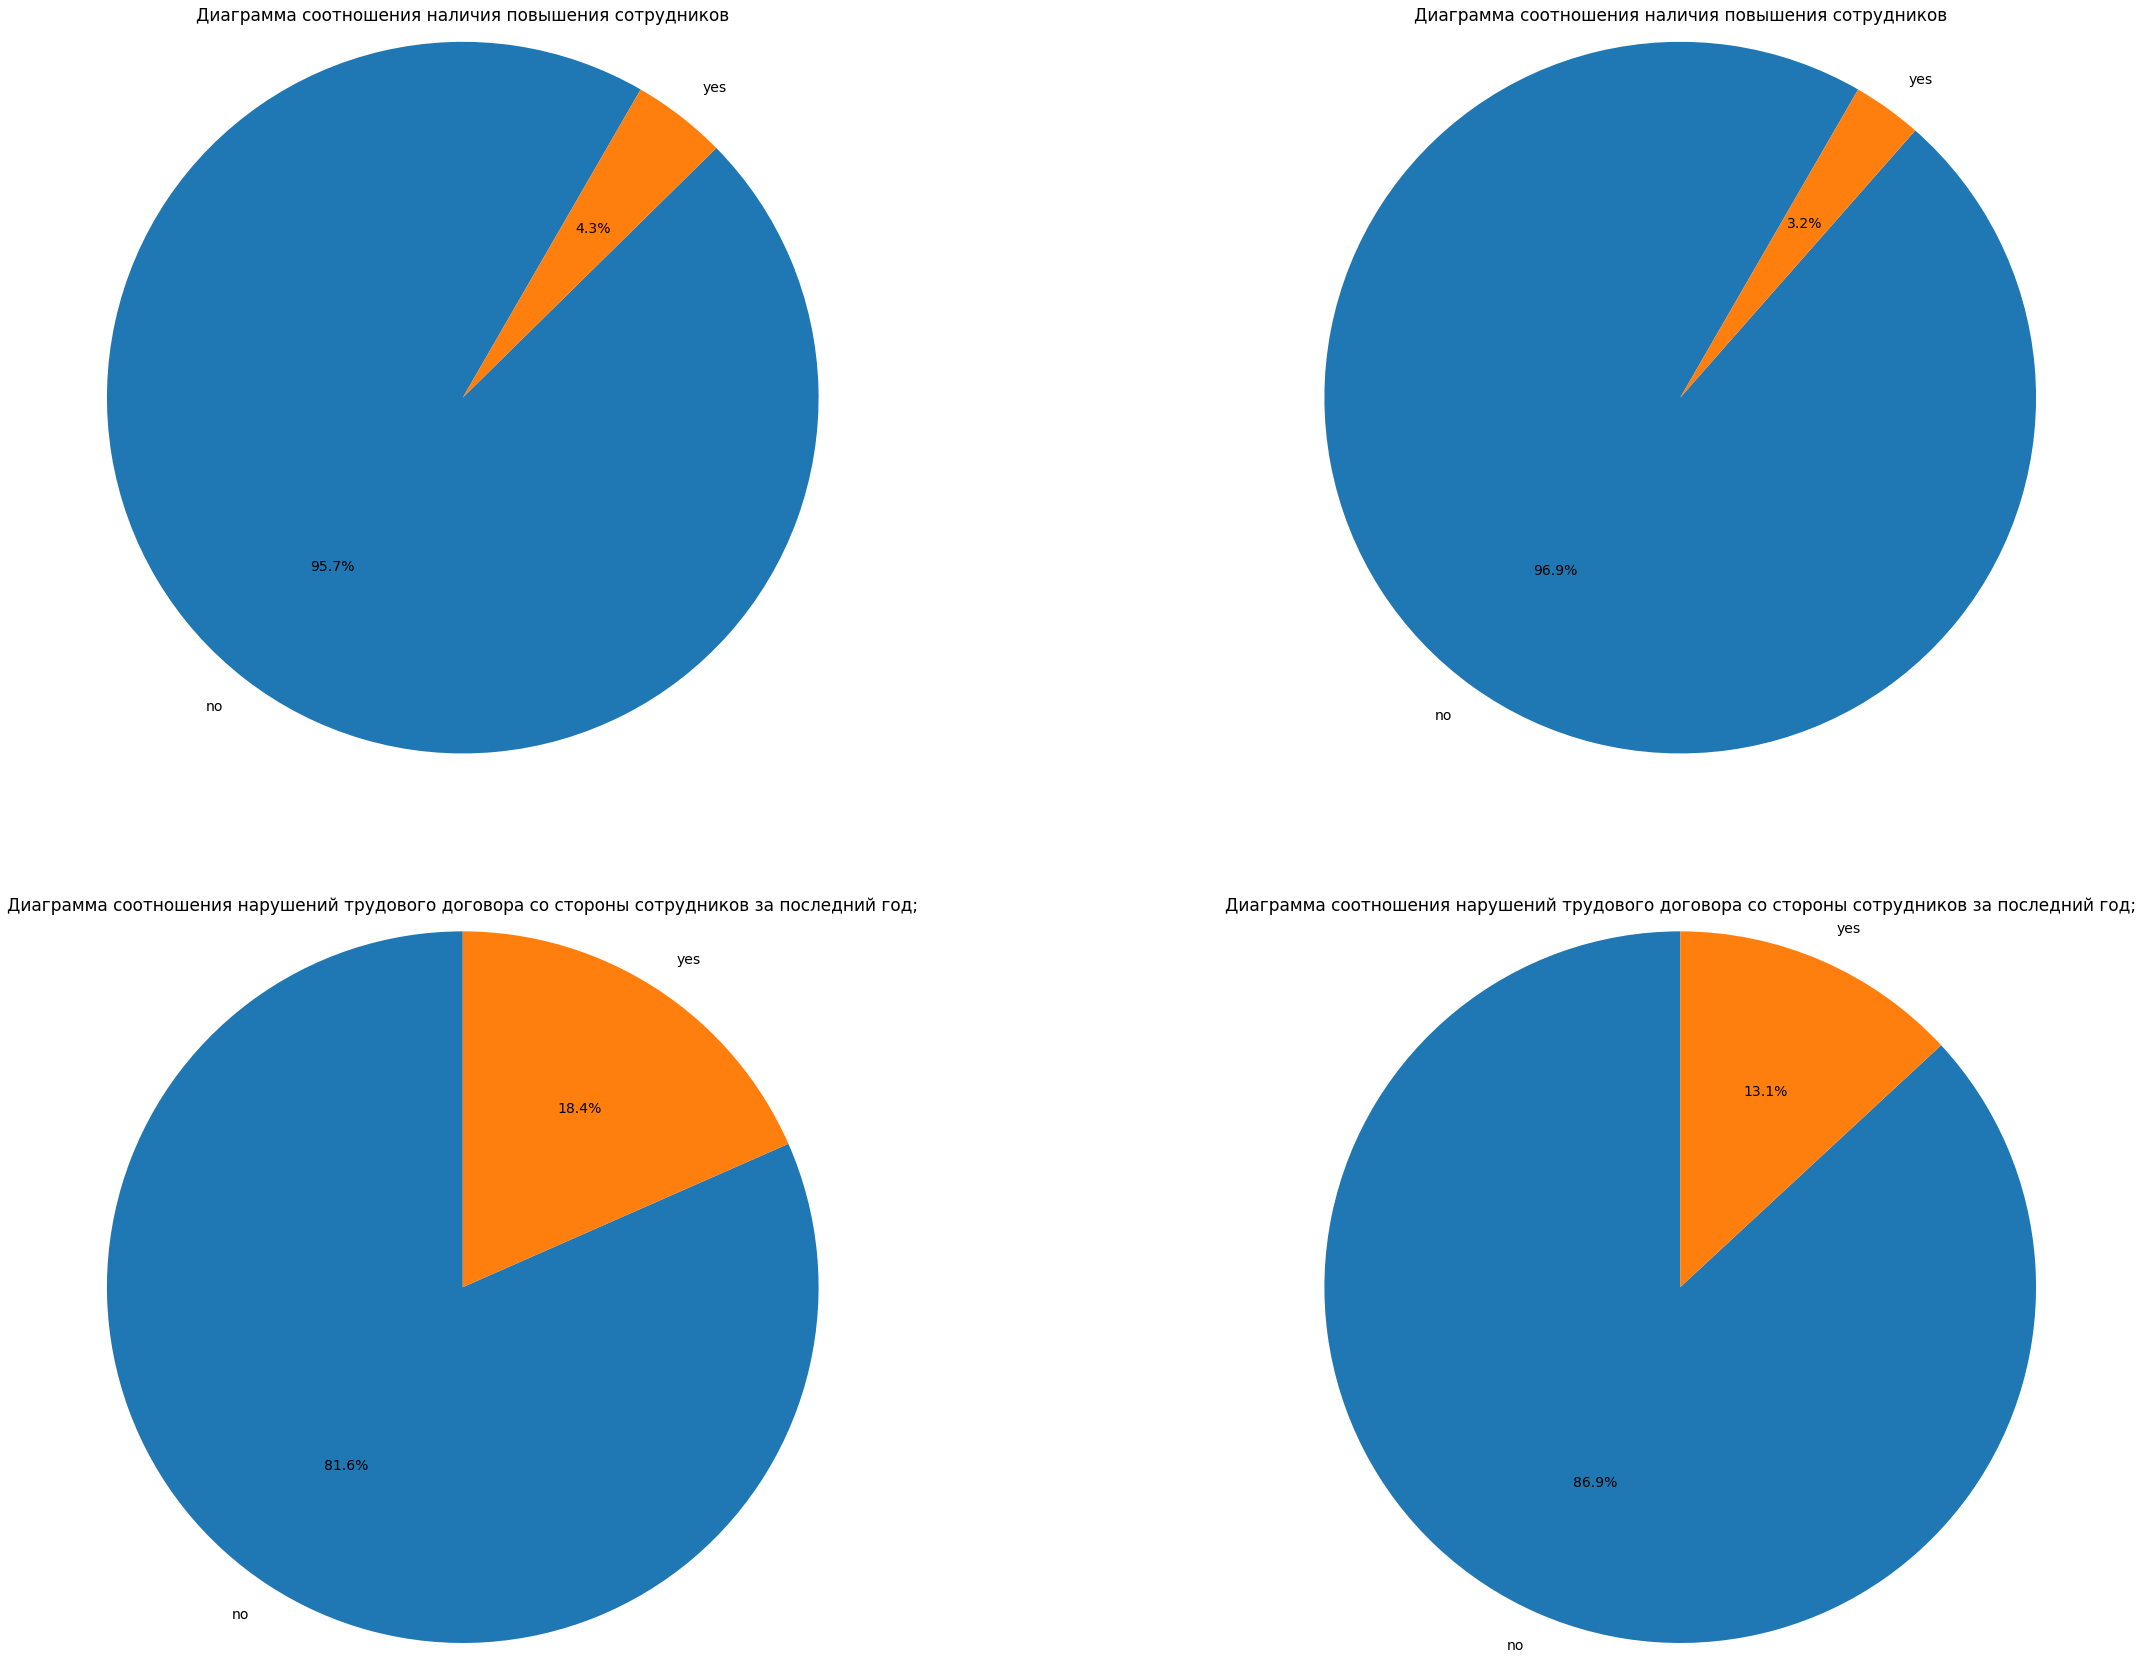

In [94]:
fig,axes = plt.subplots(2,2, figsize=(40,30))
pie(train_quit['last_year_promo'], 'наличия повышения сотрудников', 60, axes[0,0])
pie(test_features['last_year_promo'], 'наличия повышения сотрудников', 60, axes[0,1])
pie(train_quit['last_year_violations'], 
    'нарушений трудового договора со стороны сотрудников за последний год;', 90, axes[1,0])
pie(test_features['last_year_violations'], 
    'нарушений трудового договора со стороны сотрудников за последний год;', 90, axes[1,1])

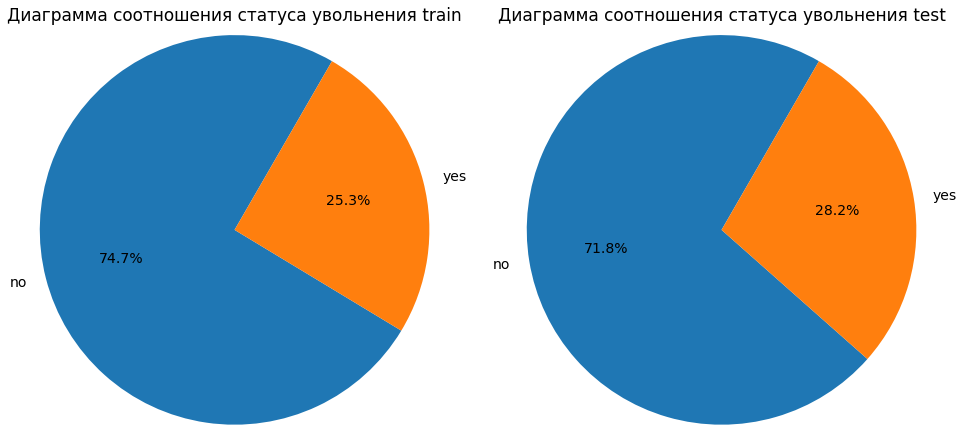

In [95]:
fig,axes = plt.subplots(1,2, figsize=(16,14))
pie(train_quit['quit'], 'статуса увольнения train', 60, axes[0])
pie(test_target_quit['quit'], 'статуса увольнения test', 60, axes[1])

**Принцип распределения категориальных признаков сохранился, посмотрим количественные. Новый признак увольнения распределен одинаково для тестовой и тренировочной выборок**

In [96]:
train_quit_col = train_quit.select_dtypes(include='number').columns.to_list()
train_quit_col.remove('id')
print(train_quit_col)

def hist_quit(first_df, second_df, target, bins, title, xname):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Тренировочная выборка
    sns.histplot(data=first_df[first_df['quit'] == 'no'], x=target, bins=bins, 
                 alpha=0.5, color='blue', label='Не уволились', ax=axes[0])
    sns.histplot(data=first_df[first_df['quit'] == 'yes'], x=target, bins=bins, 
                 alpha=0.5, color='lightblue', label='Уволились', ax=axes[0])
    axes[0].set_title('Тренировочная выборка', fontsize=14)
    axes[0].set_xlabel(xname, fontsize=12)
    axes[0].set_ylabel('Частота наблюдений', fontsize=12)
    axes[0].legend(loc='upper right')
    axes[0].grid(True)
    
    # Тестовая выборка
    sns.histplot(data=second_df[second_df['quit'] == 'no'], x=target, bins=bins, 
                 alpha=0.5, color='red', label='Не уволились', ax=axes[1])
    sns.histplot(data=second_df[second_df['quit'] == 'yes'], x=target, bins=bins, 
                 alpha=0.5, color='pink', label='Уволились', ax=axes[1])
    axes[1].set_title('Тестовая выборка', fontsize=14)
    axes[1].set_xlabel(xname, fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True)
    
    fig.suptitle(f'График распределения {title}', fontsize=16)
    plt.tight_layout()
    plt.show()

['employment_years', 'supervisor_evaluation', 'salary']


In [97]:
test_features_merged = test_features.merge(test_target_job_st, on='id', how='left')
test_features_merged = test_features_merged.merge(test_target_quit, on='id', how='left')
test_features_merged.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
quit                     0
dtype: int64

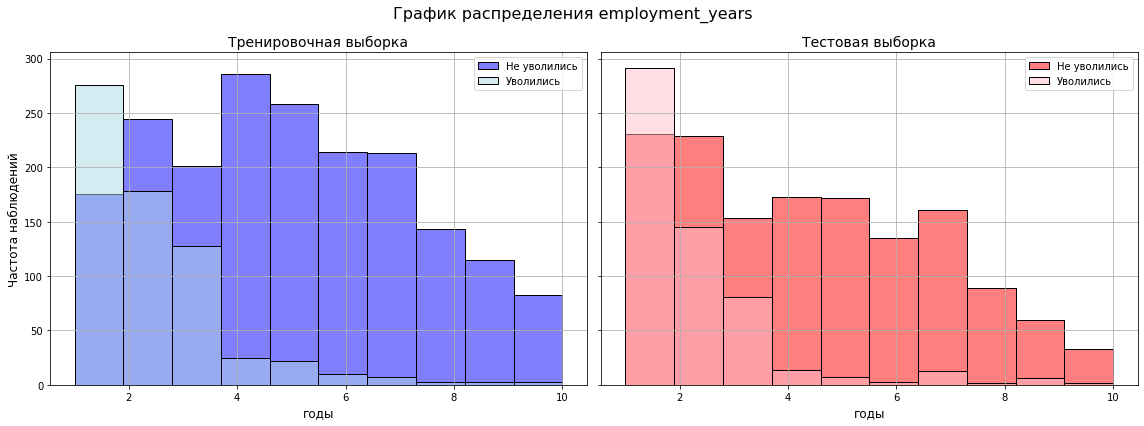

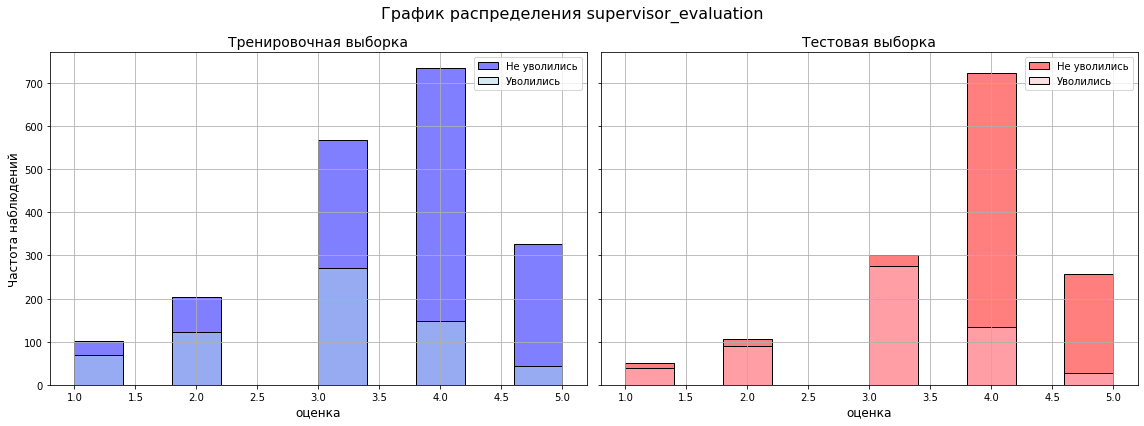

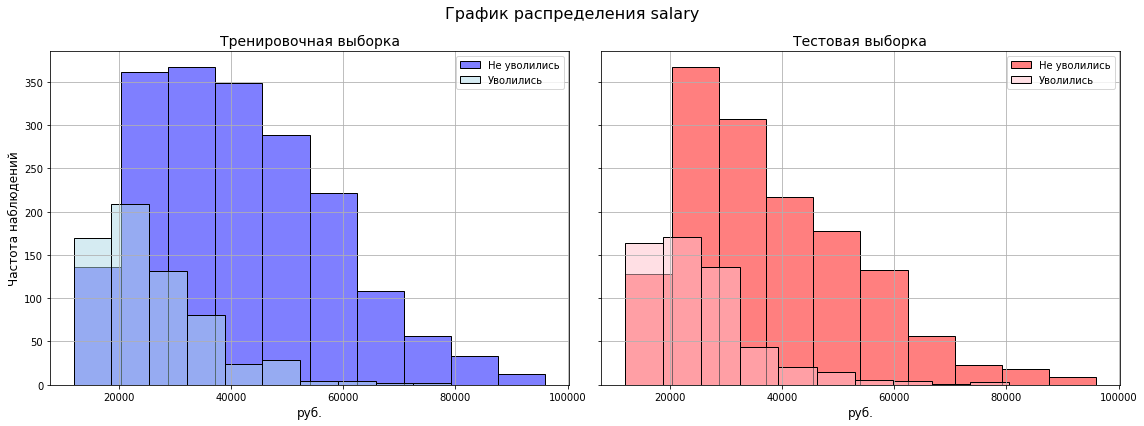

In [98]:
for i in train_quit_col:
    # Определяем значение для 'k' в зависимости от текущей колонки
    if i == 'employment_years':
        k = 'годы'
    elif i == 'supervisor_evaluation':
        k = 'оценка'
    elif i == 'salary':
        k = 'руб.'
    else:
        # Установить значение по умолчанию, если колонка не совпадает
        k = 'значение'

    # Вызываем функцию для построения графика
    hist_quit(train_quit, test_features_merged, i, 10, i, k)

**Распределение количественных данных в тренировочной и тестовой таблицах также пропорциональны и аномальных значений не наблюдается**

**В основном, увольняются сотрудники с низкой ЗП и стажем работы до ~3 лет. При этом оценка руководителя 3-4 балла чаще всего, что немного странно**

### Задача 2: Корреляционный анализ

In [99]:
def scatter_quit(feature_first,feature_second):
    plt.figure(figsize=(12,8))
    sns.scatterplot(data=test_features_merged, x=feature_first, y=feature_second, 
                    alpha=0.3, color='green', hue='quit', palette = ['orange', 'blue'])
    plt.title(f'График распределения признаков относительно целевого', fontsize=14)
    plt.xlabel(f'{feature_first}', fontsize=14)
    plt.ylabel(f'{feature_second}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    

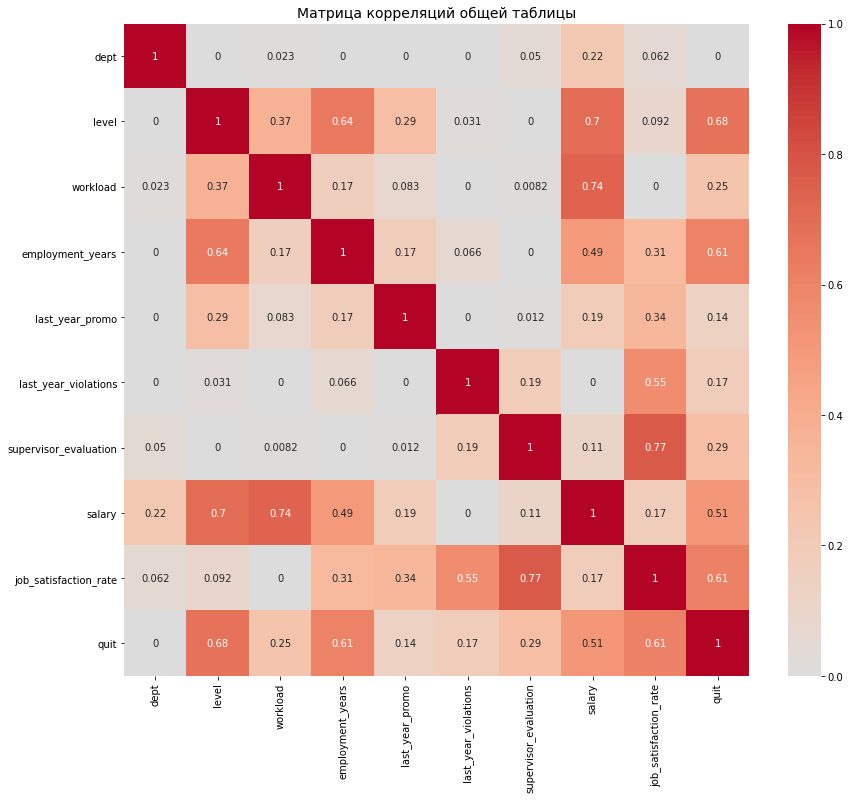

In [100]:
corr_new = test_features_merged.drop('id', axis=1).copy()
col_corr_new = corr_new.select_dtypes(include='number').columns.to_list()
corr_new_tz = corr_new.phik_matrix(interval_cols=col_corr_new)

plt.figure(figsize=(14,12))
sns.heatmap(data=corr_new_tz, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций общей таблицы', fontsize=14)
plt.show()

**Предположение аналитиков подтверждается, уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Коэффициент корреляции 0.61**

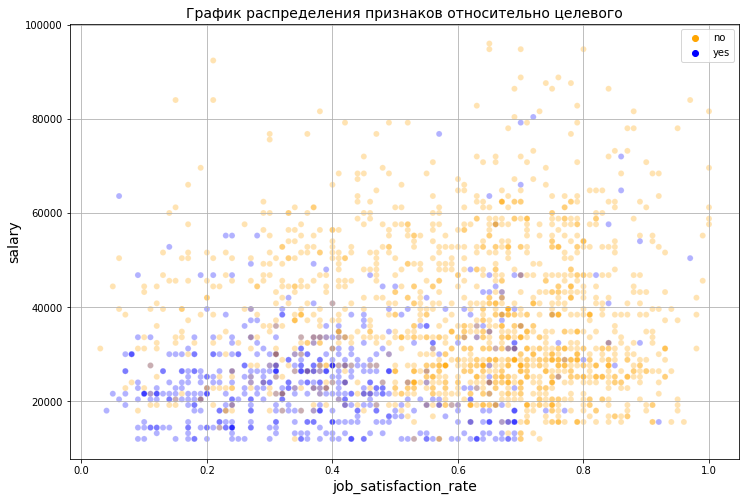

In [101]:
scatter_quit('job_satisfaction_rate', 'salary')

**На данном графике отлично видно, как разделяются точки по признаку уволился / не уволился. Увольняются почти всегда сотрудники с зп от 10 дл 40 тыс. руб. с оценкой удовлетворенности своей работой от 0.1 до 0.64.**

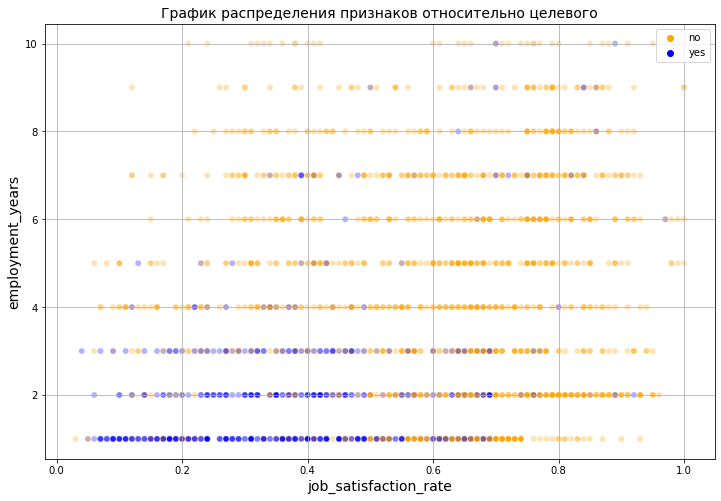

In [102]:
scatter_quit('job_satisfaction_rate', 'employment_years')

**По сроку трудоустройства и оценке удовлетворенности своей работой у нас тоже прослеживается отличное разделение на классы. Увольняются сотрудники со стажем от 0 до 4 лет и оценкой удовлетвореннсти от 0.2 до 0.55.**

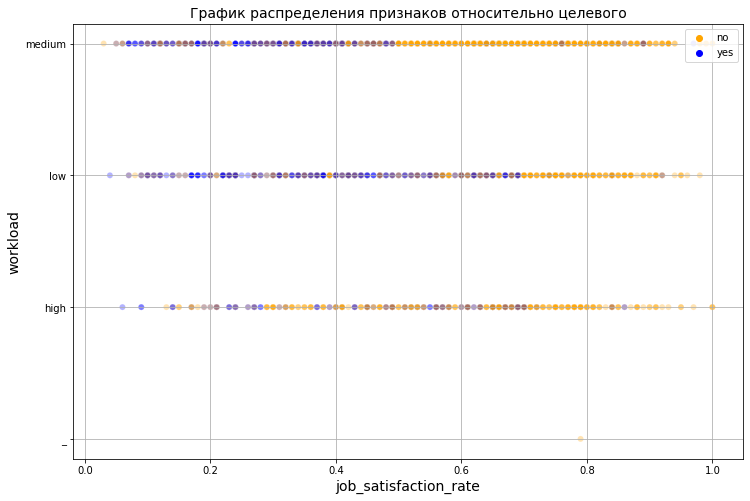

In [103]:
scatter_quit('job_satisfaction_rate', 'workload')

**По загруженности нет такого четкого разделения, но с высокой нагрузкой сотрудники увольняются гораздо реже**

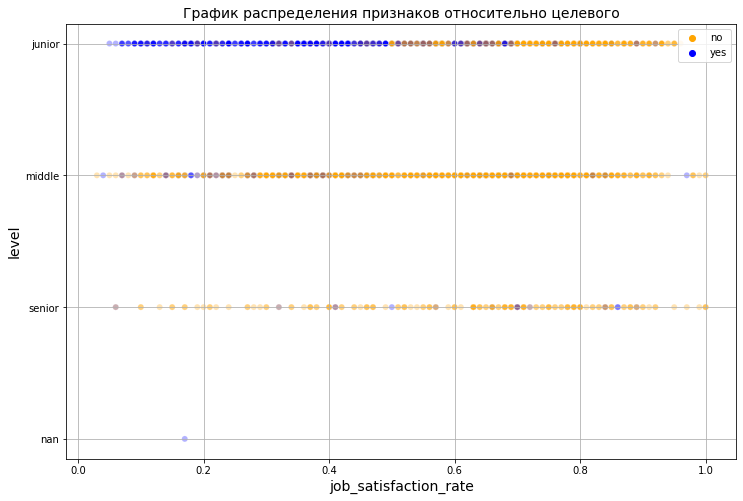

In [104]:
scatter_quit('job_satisfaction_rate', 'level')

**Касательно занимаемой должности - видим, чтьо увольняются почти всегда только junior специалисты и оценкой своей работы от 0.1 до 0.5**

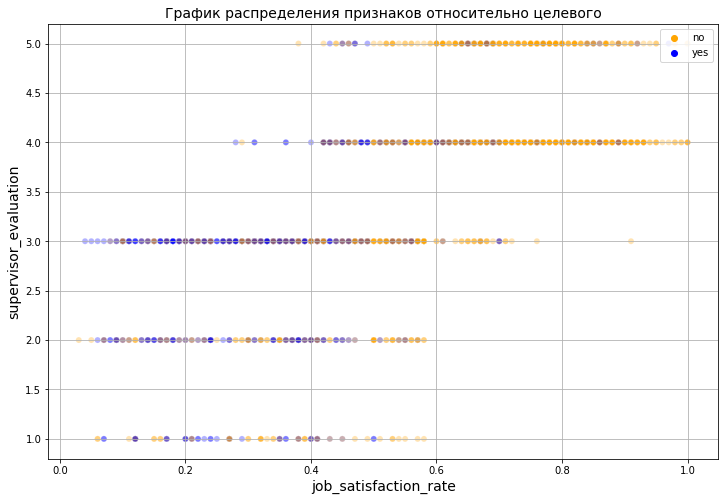

In [105]:
scatter_quit('job_satisfaction_rate', 'supervisor_evaluation')

**Если для сравнения добавляем оценку руководителя - не наблюдаем четкой кластеризации. На мой взгляд, здесь большее влияние на увольнение оказывает заработная плата и несоответствие ожиданий сотрудника с действительностью рабочих задач в компании. Возможно существует какая-то система штрафов о которой мы не знаем? Может быть ставятся задачи, не соответствующие заработной плате. Тут только уточнять у заказчика.**

### Итог раздела:
- Значительная зависимость quit (значение увольнения) с job_satisfaction_rate 0.61
- Значительная зависимость quit (значение увольнения) с employment_years 0.61
- Заметная зависимость quit с (значение увольнения) salary - 0.51
- Слабая зависимость quit (значение увольнения) с level и suprvisor_evaluation - 0.29

**У нас складывается определенный портрет сотрудника, который с большой вероятностью уволится из компании:**
- Junior специалист;
- Стаж работы от 0 до 4 лет;
- Уровень загруженности низкий/средний;
- Зарплата от 10 до 40 тыс. руб.

## Добавление нового входного признака

In [114]:
X_train_final = train_quit.copy()
X_train_final = X_train_final.drop(['id','quit'], axis=1)
X_train_final['salary^3'] = X_train_final['salary'] ** 3
X_train_final['supervisor_evaluation^3'] = X_train_final['supervisor_evaluation'] ** 3
X_train_final['employment_years^3'] = X_train_final['employment_years'] ** 3
X_train_final['employment_x_salary'] = X_train_final['employment_years'] * X_train_final['salary']

y_pred_train = best_pipeline.predict(X_train_final)
X_train_final['job_satisfaction_rate'] = y_pred_train

y_train_final = train_quit['quit'].copy()

test_quit_final = test_merged_table.merge(test_target_quit, how='right', on='id')
X_test_final = test_quit_final.drop(['id','quit','job_satisfaction_rate'], axis=1)
X_test_final['salary^3'] = X_test_final['salary'] ** 3
X_test_final['supervisor_evaluation^3'] = X_test_final['supervisor_evaluation'] ** 3
X_test_final['employment_years^3'] = X_test_final['employment_years'] ** 3
X_test_final['employment_x_salary'] = X_test_final['employment_years'] * X_test_final['salary']

y_pred_test = best_pipeline.predict(X_test_final)
X_test_final['job_satisfaction_rate'] = y_pred_test

y_test_final = test_quit_final['quit'].copy()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
test_features_merged

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.14,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.11,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.43,no


In [60]:
y_test_final

0       yes
1        no
2        no
3        no
4       yes
       ... 
1995    yes
1996    yes
1997     no
1998     no
1999    yes
Name: quit, Length: 2000, dtype: object

## Теперь строим пайплайн для предсказания quit

In [115]:
#random_state (r_s) = 42
ohe_columns_new = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns_new = ['level', 'workload']
num_columns_new = X_train_final.select_dtypes(include='number').columns.to_list()

#0 = 'no', 1 = 'yes'
original_classes = ['no', 'yes']
le_custom = LabelEncoder()
le_custom.classes_ = np.array(original_classes)
y_train_encoded = le_custom.fit_transform(y_train_final)
y_test_encoded = le_custom.transform(y_test_final)

ohe_pipe_new = Pipeline(
    [
        ('simpleImputerOhe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

ord_pipe_new = Pipeline(
    [
        ('simpleImputerBeforeOrd', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
        categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ],
        handle_unknown='use_encoded_value', unknown_value=np.nan
        )),
        ('simpleImputerAfterOrd', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor_new = ColumnTransformer(
    [
        ('ohe', ohe_pipe_new, ohe_columns_new),
        ('ord', ord_pipe_new, ord_columns_new),
        ('num', StandardScaler(), num_columns_new)
    ],
    remainder='passthrough'
)

pipeline_new = Pipeline(
    [
        ('preprocessor_new', data_preprocessor_new),
        ('model', LogisticRegression(random_state = r_s))
    ]
)

param_grid_new = [
    {
        'model': [DecisionTreeClassifier(random_state=r_s)],
        'model__max_depth': range(2,10),
        'model__min_samples_leaf': range(1,10),
        'preprocessor_new__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'model': [SVC(random_state=r_s, probability=True)],
        'model__C': [1,2],    
        'model__kernel': ['linear', 'rbf', 'poly'],
        'preprocessor_new__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'model': [LogisticRegression(random_state=r_s)],
        'preprocessor_new__num': [StandardScaler(), MinMaxScaler()]
    }
]

search_quit = GridSearchCV(
    estimator = pipeline_new,
    param_grid = param_grid_new,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 3
)

search_quit.fit(X_train_final, y_train_encoded)

print('ROC_AUC для лучшей модели на тренировочной выборке:\n', search_quit.best_score_)
print('\nЛучшая модель и ее параметры:\n\n', search_quit.best_estimator_)

result = pd.DataFrame(search_quit.cv_results_)
print(result[
    ['rank_test_score', 'param_model', 'mean_test_score']
].sort_values('rank_test_score').head(5))


y_pred_quit = search_quit.best_estimator_.predict_proba(X_test_final)[:,1]
roc_auc = roc_auc_score(y_test_encoded, y_pred_quit)

print ('\nROC_AUC для лучшей модели на тестовой выборке:\n', roc_auc.round(3))

ROC_AUC для лучшей модели на тренировочной выборке:
 0.9046056885469543

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor_new',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputerOhe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Лучшей моделью стала модель опорных векторов SVC(), а результат метрики ROC_AUC на тестовой выборке = 0.91, что говорит о том, что модель успешно справилась с задачей**

**Перейдем к интерпретации модели**

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


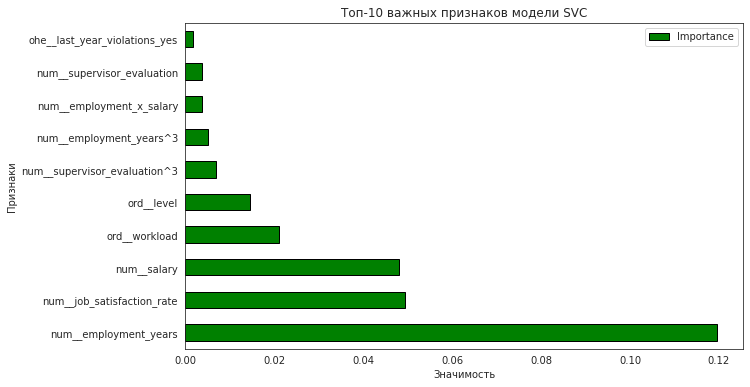

In [116]:
best_model = SVC(C=2, probability=True, random_state=42)

X_train_preprocessed = pipeline_new.named_steps['preprocessor_new'].fit_transform(X_train_final)
X_test_preprocessed = pipeline_new.named_steps['preprocessor_new'].transform(X_test_final)

best_model.fit(X_train_preprocessed, y_train_encoded)

# Вычисляем важность признаков с помощью permutation_importance
permutation = permutation_importance(best_model, X_test_preprocessed, y_test_encoded, scoring='roc_auc', n_repeats=10, random_state=r_s)

feature_names = data_preprocessor_new.get_feature_names_out()

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation.importances_mean  # Средняя важность признаков
})

#Сортируем по важности и выбираем 10 лучших
best_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)

#Визуализация
sns.set_style('white')
best_features.plot(x='Feature', y='Importance', kind='barh', color='green', ec='black', figsize=(10, 6))
plt.title("Топ-10 важных признаков модели SVC")
plt.xlabel("Значимость")
plt.ylabel("Признаки")
plt.show()

**Для модели SVC() наиболее значимыми являются employment_years (срок трудоустройства), workload (загруженность), job_satisfaction_rate, salary.**

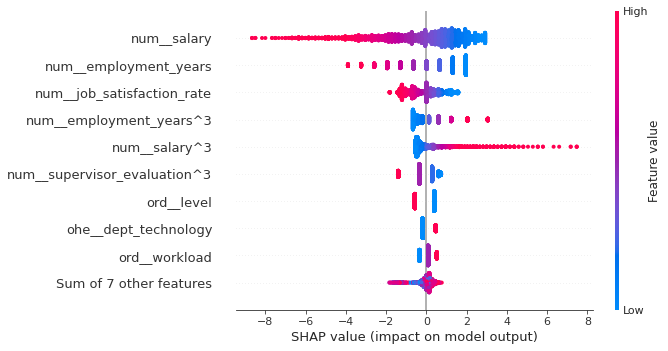

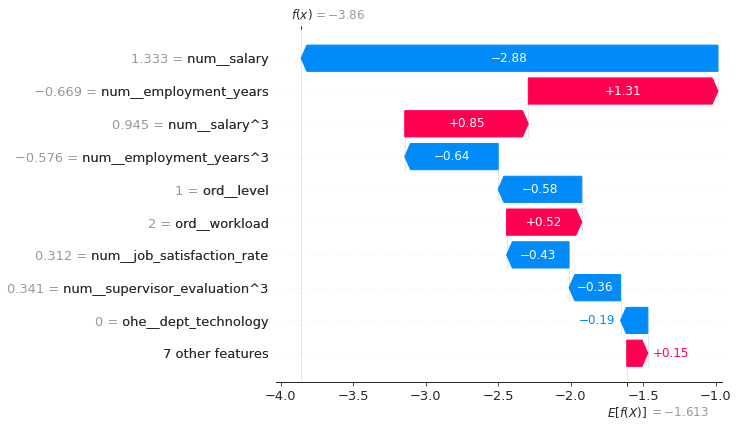

In [140]:
true_model = pipeline_new.named_steps['model']
true_model.fit(X_train_preprocessed, y_train_encoded)

X_train_preprocessed = pd.DataFrame(data=X_train_preprocessed, columns=data_preprocessor_new.get_feature_names_out())
explainer_true = shap.LinearExplainer(true_model, X_train_preprocessed)
shap_values = explainer_true(X_train_preprocessed)

shap.plots.beeswarm(shap_values) 
shap.plots.waterfall(shap_values[0]) 

**К статусу "уволится" склоняют следующие признаки и их значения:**
- Ниже стаж работы в организации -> повышение вероятности увольнения;
- Ниже оценка удовлетворенности своей работой сотрудника -> повышение вероятности увольнения;
- Ниже загруженность -> повышение вероятности увольнения;
- Низкая зарплата -> повышение вероятности увольнения;
- Низкая должность -> повышение вероятности увольнения.

### Итоги раздела:
- Лучшей моделью для предсказания увольнения стала модель опорных векторов SVC(), а показатель метрики на тестовых данных составил 0.92. Модель отлично справляется с поставленной задачей.

- На принятие решения модели более остальных влияют следующие признаки: *employment_years (срок трудоустройства), salary, workload (загруженность), job_satisfaction_rate*

## Заключение

**Задачей №1 данного проекта являлась разработка модели для предсказанию оценки удовлетворенности сотрудников своей работой на основе данных заказчика**

*Недовольны своей работой в основном новички на должностях junior и middle с заработной платой от 20 по 40 тыс.руб.*

*Модель Decision Tree справилась лучше, потому что она многоуровневая и способна к обработке категориальных признаков. Также замечает не только линейные зависимости.*

*Важнее всех для предсказаний модели являются признаки: supervisor_evaluation^3, employment_years, last_year_violations, level. Их значения лучше всего описывают целевой.*

**Задачей №2 данного проекта являлась разработка модели, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.**

*Сотрудник скорее всего уволится, если он Junior специалист; Стаж работы от 0 до 4 лет; Уровень загруженности низкий/средний; Зарплата от 10 до 40 тыс. руб., с низкой оценкой удовлетворенности своей работой*

*Модель SVC() (метод опорных векторов) лучше остальных справилась с задачей*

*На принятие решения модели более остальных влияют следующие признаки: employment_years (срок трудоустройства), workload (загруженность), job_satisfaction_rate, salary*


**Для поиска лучшей модели был выбран метод Optuna, поскольку позволяет рассмотреть большое количество комбинаций в короткий срок и дать точные результаты.**

**Данные в изначальных таблицах были распределены нормально, пропусков и янвых дубликатов обнаружено не было. Провел исследовательский и корреляционный анализ признаков.**